In [1]:
import torch.nn as nn
import torch
from torch import linalg as LA
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR
import seaborn as sn



In [3]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
from utils import ExecutionLoss, Wealth, Market
from model import WealthMax, AnaSolMaxWealth, AnaSolMaxWealth_driftcon
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
torch.set_default_device(device)
# Set a random seed for PyTorch
seed = 20020829  
torch.manual_seed(seed)

## KDE and histogram helpers



In [101]:


def kde_choose_band(action_tensor, bd):
    num_samples, time_steps, num_stocks = action_tensor.shape

    # Create a single figure with two subplots side by side
    

    for stock_index in range(num_stocks):
        # Extract the data for the current stock
        fig, axs = plt.subplots(1, time_steps-1, figsize=(16, 5), sharex=True, sharey=True)
        data = action_tensor[:, :, stock_index]
        
        # Create a KDE plot and a histogram for each time step
        for time_step in range(time_steps)[1:]:
            sn.kdeplot(data[:, time_step], label=f"Time Step {time_step+1}", ax=axs[time_step-1], bw_method=bd, common_norm=True)
            


        # Set labels and title for the subplot
            axs[time_step-1].set_title(f"time step {time_step + 1}")
            axs[time_step-1].set_xlabel("Num of shares")
            axs[time_step-1].set_ylabel("Probability Density")

        # Adjust spacing between subplots
        plt.tight_layout()

        # Set the title for the entire figure
        fig.suptitle(f"KDE Plot for Stock {stock_index + 1}")
        # Show or save the plot
        plt.show()

def histogram(action_tensor,action_tensor_bench):
    num_samples, time_steps, num_stocks = action_tensor.shape

    
    # Create a single figure with two subplots side by side
    for stock_index in range(num_stocks):
        # Extract the data for the current stock
        fig, axs = plt.subplots(2, time_steps-1, figsize=(12, 5), sharex=True)

        for i, (model, action) in enumerate(zip(["Benchmark", "Our Model"], [action_tensor_bench, action_tensor])):
            data = action[:, :, stock_index]

            # Create a KDE plot and a histogram for each time step
            for time_step in range(action_tensor.shape[1])[1:]:
                
                sn.histplot(data[:, time_step], color="red", kde=False, element="step", label=f"Time Step {time_step}", ax=axs[i, time_step-1])
                
                
            

            # Set labels and title for the subplot
                axs[i, time_step-1].set_title(f"{model} time step {time_step + 1}")
                axs[i, time_step-1].set_xlabel("Num of shares")
                axs[i, time_step-1].set_ylabel("Count")
                axs[i, time_step-1].legend()

            # Adjust spacing between subplots
        plt.tight_layout()

        # Set the title for the entire figure
        fig.suptitle(f"Histogram for Stock {stock_index + 1}")
        # Show or save the plot
        plt.show()

def simulate_action(params, init_state, model, model_test, time_num, batch_size, process):
    """
    Simulate the action for time_num many of time steps from the model and the benchmark model, respectively for a given initial state and parameters.
    
    Precondition: 
    - process can be "OU" or "brownian"
    """

    ## make init_state to have batch dimension 
    init_state = init_state.repeat(batch_size, 1).to(device)
    market = Market(num_stock = params['num_stock'], num_brownian = params['num_brownian'], batch_size= batch_size, process_for_zeta= process, k = params['k'], sig_z = params['sig_z'], dt = params['dt'])
    model.set_market_simulator(market)
    model_test.set_market_simulator(market)
    model.eval()
    model_test.eval()

    
    with torch.no_grad():
        
        action, _ = model(init_state)
        action_bench, _ = model_test(init_state)
        time_steps = action.shape[1]
        gap = time_steps//time_num
        #only get the action_tensor for the time steps we want
 
        action = action[:,::gap,:]
        action_bench = action_bench[:,::gap,:]

        # print the time index we got
        print("The time index we are simulating is: ", np.arange(0, time_steps, gap))


    #put it on cpu and numpy
    action_for_plot = action.cpu().numpy()
    action_bench_for_plot = action_bench.cpu().numpy()

    return action_for_plot, action_bench_for_plot


def plot_kde(action_tensor, action_tensor_bench, bandwidth = 'scott'):
    num_samples, time_steps, num_stocks = action_tensor.shape

    # Create a single figure with two subplots side by side, one for benchmark one for our model
    for stock_index in range(num_stocks):
        fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
        for i, (model, action) in enumerate(zip(["Benchmark", "Our Model"], [action_tensor_bench, action_tensor])):
            # Extract the data for the current stock
            data = action[:, :, stock_index]
            # Create a KDE plot for each time step
            
            
            for time_step in range(time_steps)[1:]:
                sn.kdeplot(data[:, time_step], label=f"Time Step {time_step}", ax=axs[i], bw_method=bandwidth, common_norm=True)

            # Set labels and title for the subplot
            axs[i].set_title(f"KDE Plot for Stock{stock_index+1} for {model}")
            axs[i].set_xlabel("Num of shares")
            axs[i].set_ylabel("Probability Density")
            axs[i].legend()

        # Adjust spacing between subplots
        plt.tight_layout()
        # Set the title for the entire figure
        # Show or save the plot
        plt.show()

## Train helper

In [6]:
def train(params, model, model_test, criterion, opt, state):
    loss_for_plot = []
    loss_var_for_plot = []
    loss_for_plot_benchmark = []
    model.train()

    for i in range(params["batches"]):
        
        action, params = model(state)
        mu = params['mu']
        sigma = params['sigma']
        zeta = params['zeta']
        bt = params['bt']
        lamda = params['lamda']

        
        
        # for j in range(lamda.shape[0]):
        #     if lamda[j,:] != 0:
        #         print(f'iteration {i}, batch {j+1} lambda is not zero')
        #         print(lamda[i,:])

        opt.zero_grad()
        loss_batch = criterion(action, mu, sigma, zeta, bt,lamda).to(torch.float)
        loss = - torch.mean(loss_batch,dim=0).to(torch.float)
        loss.backward()
        opt.step()
        loss_for_plot.append(-loss.item())
        loss_var_for_plot.append(torch.var(loss_batch).item())
        
        
        action_bench, params_bench = model_test(state)
        mu = params_bench['mu']
        sigma = params_bench['sigma']
        zeta = params_bench['zeta']
        bt = params_bench['bt']
        lamda = params_bench['lamda']
        loss_batch = criterion(action_bench, mu, sigma, zeta, bt,lamda).to(torch.float)
        loss_bench = torch.mean(loss_batch,dim=0).to(torch.float)
        loss_for_plot_benchmark.append(loss_bench.item())

        
        if i % 100 == 0:
            print(f"Iteration: {i}, Reward: {-loss.item()}")
           
            print(f"Iteration: {i}, Reward_benchmark: {loss_bench.item()}")
      

            


    return loss_for_plot, loss_for_plot_benchmark, loss_var_for_plot

## Wealth Maximization Problem with 1 stock & Time step =3



In [21]:
params = {"batch_size": 64, 'hidden_size': 100, "lr": 1e-3, "batches": 1500, "time_step": 5, "num_stock": 1, "num_brownian": 1, 'dt': 0.1, 'k':1, 'sig_z':0.1, 'gamma':1}
mu = torch.tensor([[1]]).type(torch.cuda.FloatTensor)
sigma = torch.tensor([[0.5]]).type(torch.cuda.FloatTensor)
zeta = torch.tensor([[0]]).type(torch.FloatTensor).to(device)

init_param = {'geo_param':(mu,sigma), 'zeta': zeta, 'bt': torch.tensor([0]).type(torch.FloatTensor).to(device)}
state = torch.tensor([[150, 50, 0]]).type(torch.FloatTensor)
# repeat state for batch size
state = state.repeat(params['batch_size'], 1).to(device)


market = Market(num_stock = params['num_stock'], num_brownian = params['num_brownian'], batch_size=params['batch_size'], process_for_zeta='OU', k = params['k'], sig_z = params['sig_z'], dt=params['dt'])
model_simple = WealthMax(market,time_step=params['time_step'], num_brownian=params['num_brownian'], num_stock=params['num_stock'], dt=params['dt'], gamma=params['gamma']).to(device)
model_simple.set_init_system_parameter(geo_param = init_param['geo_param'], zeta = init_param['zeta'], bt = init_param['bt'])

model_test_s = AnaSolMaxWealth(market, time_step=params['time_step'], num_brownian=params['num_brownian'], num_stock=params['num_stock'], dt=params['dt'], gamma=params['gamma']).to(device)
model_test_s.set_init_system_parameter(geo_param = init_param['geo_param'], zeta = init_param['zeta'], bt = init_param['bt'])


opt = Adam(model_simple.parameters(), lr=params["lr"])

criterion = Wealth(dt=params['dt'], gamma=params['gamma'])




In [22]:


loss_for_plot, loss_for_plot_benchmark, loss_var_for_plot= train(params, model_simple, model_test_s, criterion, opt, state)

        

Iteration: 0, Reward: -1.112764596939087
Iteration: 0, Reward_benchmark: 9.972237586975098
Iteration: 100, Reward: 9.588942527770996
Iteration: 100, Reward_benchmark: 10.017959594726562
Iteration: 200, Reward: 9.909640312194824
Iteration: 200, Reward_benchmark: 10.001195907592773
Iteration: 300, Reward: 9.912091255187988
Iteration: 300, Reward_benchmark: 9.998948097229004
Iteration: 400, Reward: 10.006478309631348
Iteration: 400, Reward_benchmark: 10.028844833374023
Iteration: 500, Reward: 9.923322677612305
Iteration: 500, Reward_benchmark: 10.036035537719727
Iteration: 600, Reward: 10.075278282165527
Iteration: 600, Reward_benchmark: 10.02330207824707
Iteration: 700, Reward: 10.011618614196777
Iteration: 700, Reward_benchmark: 10.007311820983887
Iteration: 800, Reward: 10.007430076599121
Iteration: 800, Reward_benchmark: 10.009529113769531
Iteration: 900, Reward: 9.930951118469238
Iteration: 900, Reward_benchmark: 10.023160934448242
Iteration: 1000, Reward: 9.98257827758789
Iteration:

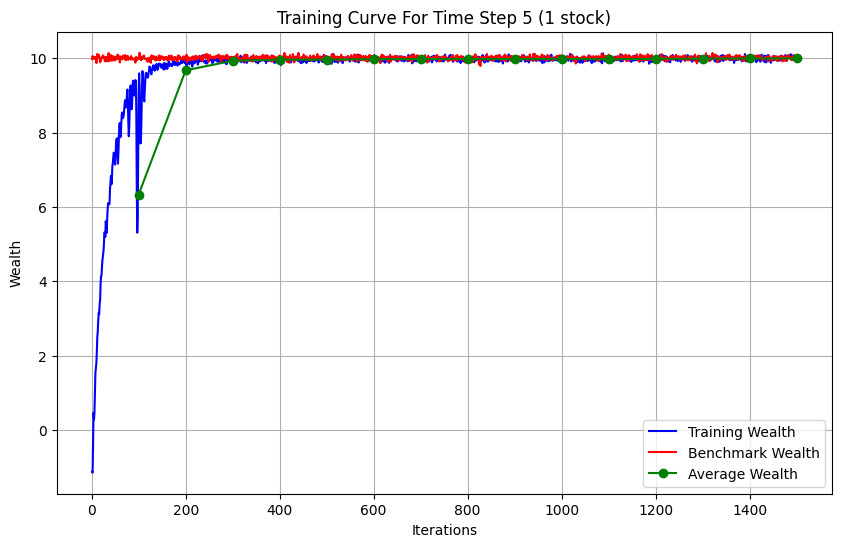

In [23]:


loss_for_plot = np.array(loss_for_plot)
loss_for_plot_benchmark = np.array(loss_for_plot_benchmark)

iterations = np.arange(1,params['batches']+1)  



# Reshape the array into groups of 100 iterations
grouped_losses = loss_for_plot[:params['batches'] - (params['batches'] % 100)].reshape(-1, 100)
average_losses = np.mean(grouped_losses, axis=1)

# Create an array representing the iteration numbers
iteration_numbers = np.arange(100, params['batches'] + 1, 100)


plt.figure(figsize=(10, 6))
plt.plot(iterations, loss_for_plot, label='Training Wealth', color='blue')
## add another line for benchmark loss
plt.plot(iterations, loss_for_plot_benchmark, label='Benchmark Wealth', color='red')
plt.plot(iteration_numbers, average_losses, marker='o', label='Average Wealth', color='green')
plt.xlabel('Iterations')
plt.ylabel('Wealth')
plt.title(f'Training Curve For Time Step {params["time_step"]} ({params["num_stock"]} stock)')
plt.grid(True)
plt.legend()
plt.show()

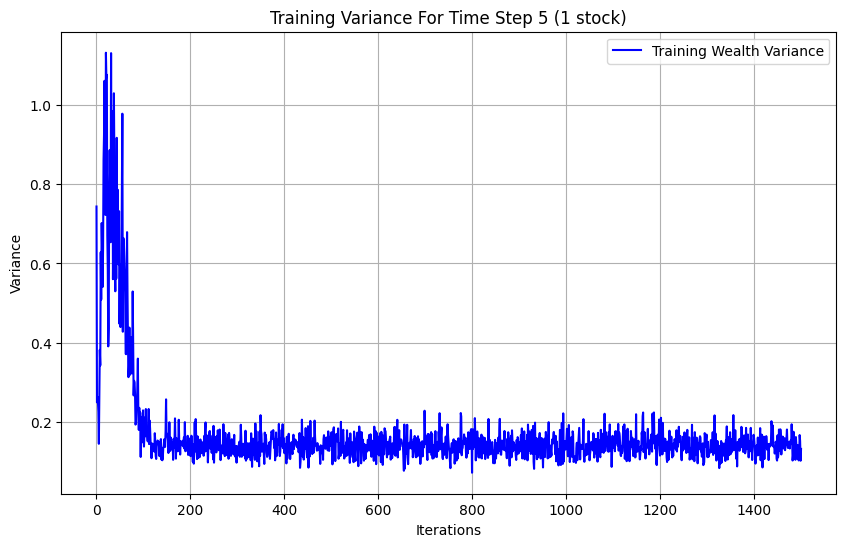

In [24]:
loss_var_for_plot = np.array(loss_var_for_plot)


iterations = np.arange(1,params['batches']+1)  



plt.figure(figsize=(10, 6))
plt.plot(iterations, loss_var_for_plot, label='Training Wealth Variance', color='blue')
## add another line for benchmark loss
plt.xlabel('Iterations')
plt.ylabel('Variance')
plt.title(f'Training Variance For Time Step {params["time_step"]} ({params["num_stock"]} stock)')
plt.grid(True)
plt.legend()
plt.show()

In [30]:
state = torch.tensor([[150, 50,0]]).type(torch.FloatTensor)
# repeat state for batch size
process = 'OU'
time_num = 5
params = {"batch_size": 64, 'hidden_size': 100, "lr": 1e-3, "batches": 1500, "time_step": 5, "num_stock": 1, "num_brownian": 1, 'dt': 0.1, 'k':1, 'sig_z':0.1, 'gamma':1}
action_for_plot_OU, action_bench_for_plot_OU = simulate_action(params, state, model_simple, model_test_s, time_num, 20000, process = process)


The time index we are simulating is:  [ 0 10 20 30 40]


In [28]:
init_state = state.repeat(12000, 1).to(device)
market = Market(num_stock = params['num_stock'], num_brownian = params['num_brownian'], batch_size= 12000, process_for_zeta= process, k = params['k'], sig_z = params['sig_z'], dt = params['dt'])
model_simple.set_market_simulator(market)
model_test_s.set_market_simulator(market)
model_simple.eval()
model_test_s.eval()



    
action, params = model_simple(init_state)
mu = params['mu']
sigma = params['sigma']
zeta = params['zeta']
bt = params['bt']
lamda = params['lamda']
loss_batch = criterion(action, mu, sigma, zeta, bt,lamda).to(torch.float)
loss_ = torch.mean(loss_batch,dim=0).to(torch.float)
print('The wealth for our model is: ', loss_.item())
action_bench, params = model_test_s(init_state)


mu = params['mu']
sigma = params['sigma']
zeta = params['zeta']
bt = params['bt']
lamda = params['lamda']
loss_batch = criterion(action_bench, mu, sigma, zeta, bt,lamda).to(torch.float)
loss_bench = torch.mean(loss_batch,dim=0).to(torch.float)
print('The wealth for the benchmark model is: ', loss_bench.item())

The wealth for our model is:  8.155817985534668
The wealth for the benchmark model is:  9.996965408325195


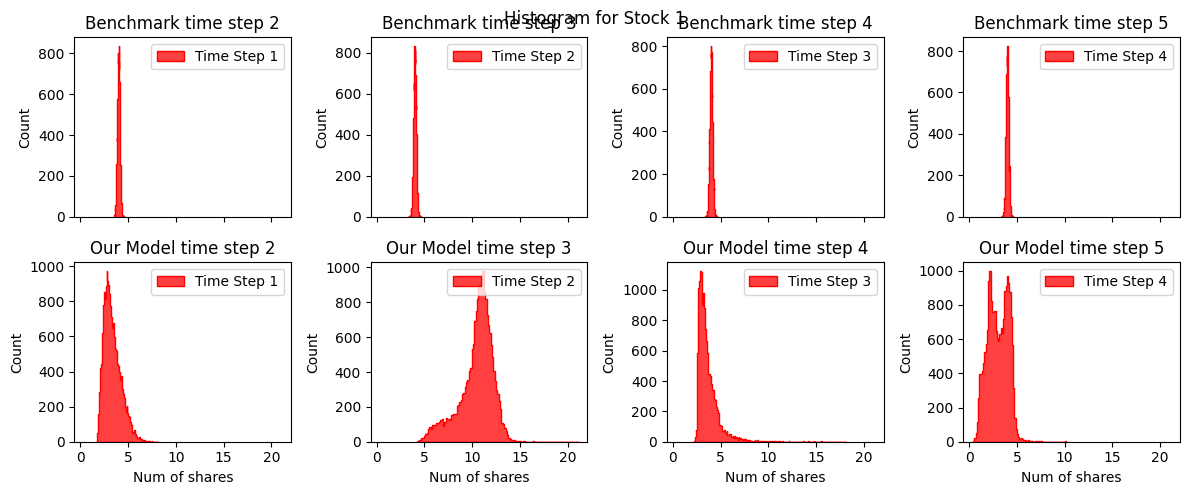

In [31]:
histogram(action_for_plot_OU, action_bench_for_plot_OU)

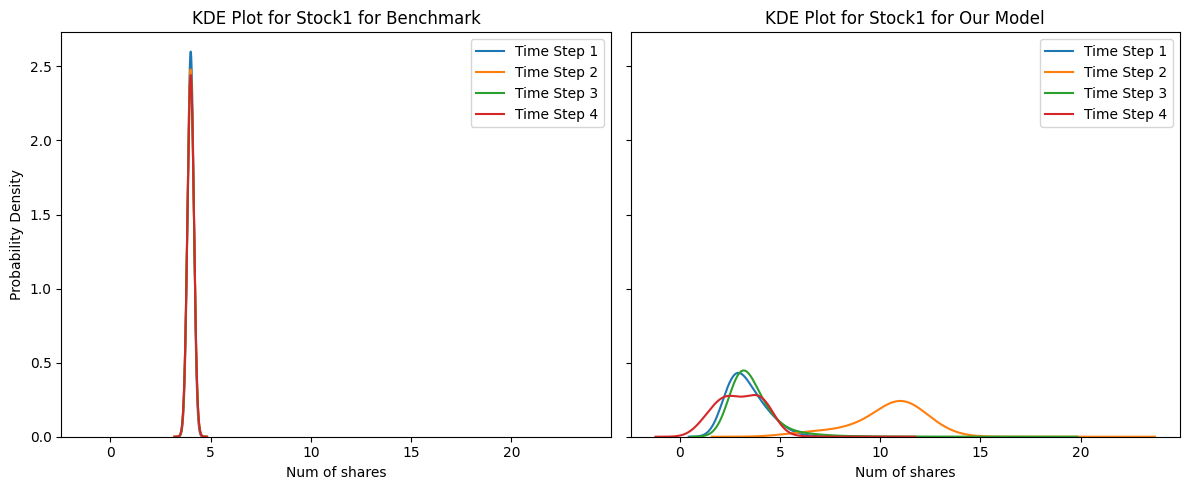

In [32]:
bandwidth=0.5


plot_kde(action_for_plot_OU, action_bench_for_plot_OU, bandwidth=bandwidth)

## Experiments with K and Sig_z

In [13]:
params = {"batch_size": 100, 'hidden_size': 100, "lr": 1e-3, "batches": 3000, "time_step": 5, "num_stock": 2, "num_brownian": 1, 'dt': 1/252, 'k':1, 'sig_z':0.1}

market = Market(num_stock = params['num_stock'], num_brownian = params['num_brownian'], batch_size=params['batch_size'], process_for_zeta='OU', k = params['k'], sig_z = params['sig_z'])
zeta =  torch.tensor([0]).type(torch.FloatTensor).unsqueeze(0).unsqueeze(0).to(device)

B_t = torch.zeros(params['batch_size'], params['num_brownian'], 1)

z = []
for t in range(int(params['time_step']/ params['dt'])):
    z_new = market.zeta_simulator(B_t = B_t, zeta=zeta, dt = params['dt']).squeeze(0).squeeze(0)
    zeta = z_new
    
    B_t = market.B_t_simulator(B_t, dt = params['dt'])
    z.append(z_new)
    
# plot z
# make z onto cpu
z = torch.stack(z,dim=1).squeeze(2).squeeze(2).cpu().numpy()
print(z.shape)




(100, 1260)


Text(0.5, 1.0, '5 simulations of OU process, with quantiles. k = 1 & sig_z = 0.1')

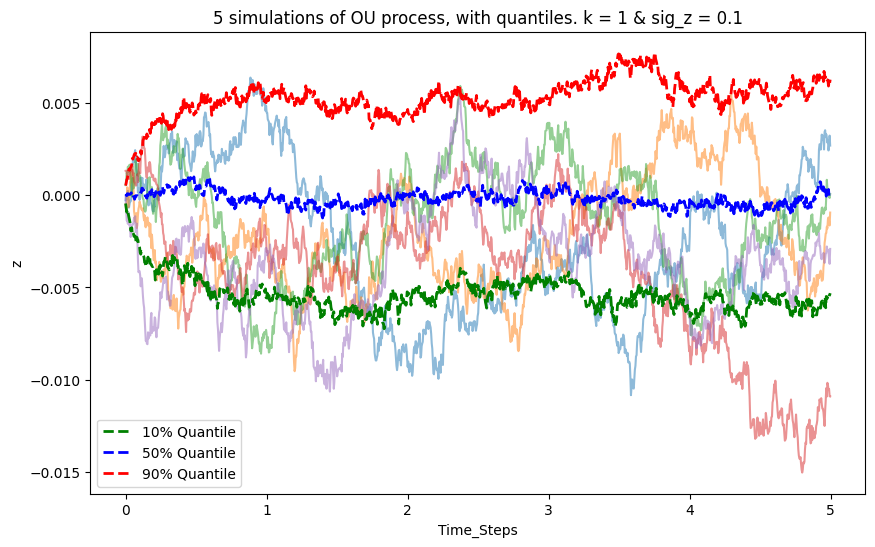

In [20]:
num_simulation = 5
plt.figure(figsize=(10, 6))
quantiles_10 = np.percentile(z, 10, axis=0)
quantiles_50 = np.percentile(z, 50, axis=0)
quantiles_90 = np.percentile(z, 90, axis=0)
# x axis is timesteps from params
time_values = np.arange(0, params['time_step'], params['dt'])
# for each of the first dimension plot, plot the time step against the value
for i in range(num_simulation):
    plt.plot(time_values, z[i,:], alpha =0.5)
    
plt.plot(time_values, quantiles_10, 'g--', label='10% Quantile', linewidth=2)
plt.plot(time_values, quantiles_50, 'b--', label='50% Quantile', linewidth=2)
plt.plot(time_values, quantiles_90, 'r--', label='90% Quantile', linewidth=2)

plt.xlabel('Time_Steps')
plt.legend()
plt.ylabel('z')
plt.title(f'{num_simulation} simulations of OU process, with quantiles. k = {params["k"]} & sig_z = {params["sig_z"]}')


## Wealth Maximization with OU process, 2 stocks, timestep =5


In [124]:
params = {"batch_size": 64, 'hidden_size': 100, "lr": 1e-3, "batches": 3500, "time_step": 5, "num_stock": 2, "num_brownian": 3, 'dt': 0.1, 'gamma': 0.1, 'k':1, 'sig_z':0.1}

mu = torch.tensor([[1],[0.5]]).type(torch.cuda.FloatTensor)
sigma = torch.tensor([[0.5,0,0],[0,0.1,0]]).type(torch.cuda.FloatTensor)
zeta = torch.tensor([[0],[0],[0]]).type(torch.FloatTensor).to(device)

init_param = {'geo_param':(mu,sigma), 'zeta': zeta, 'bt': torch.tensor([0]).type(torch.FloatTensor).to(device)}
state = torch.tensor([[150, 50,50,0, 0,0]]).type(torch.FloatTensor)
# repeat state for batch size
state = state.repeat(params['batch_size'], 1).to(device)
market = Market(num_stock = params['num_stock'], num_brownian = params['num_brownian'], batch_size=params['batch_size'], process_for_zeta='OU', k = params['k'], sig_z = params['sig_z'], dt=params['dt'])
model_simple = WealthMax(market,time_step=params['time_step'], num_brownian=params['num_brownian'], num_stock=params['num_stock'], dt=params['dt'], gamma=params['gamma']).to(device)
model_simple.set_init_system_parameter(geo_param = init_param['geo_param'], zeta = init_param['zeta'], bt = init_param['bt'])

model_test = AnaSolMaxWealth(market, time_step=params['time_step'], num_brownian=params['num_brownian'], num_stock=params['num_stock'], dt=params['dt'], gamma=params['gamma']).to(device)
model_test.set_init_system_parameter(geo_param = init_param['geo_param'], zeta = init_param['zeta'], bt = init_param['bt'])


opt = Adam(model_simple.parameters(), lr=params["lr"])
scheduler = ExponentialLR(opt, gamma=0.95)
criterion = Wealth(dt=params['dt'], gamma=params['gamma'])


## Train


In [125]:
loss_for_plot, loss_for_plot_benchmark, loss_var_for_plot = train(params, model_simple, model_test, criterion, opt, state)

Iteration: 0, Reward: 3.993354558944702
Iteration: 0, Reward_benchmark: 725.0921630859375
Iteration: 100, Reward: 56.00596618652344
Iteration: 100, Reward_benchmark: 725.053955078125
Iteration: 200, Reward: 106.74811553955078
Iteration: 200, Reward_benchmark: 724.8565673828125
Iteration: 300, Reward: 160.36050415039062
Iteration: 300, Reward_benchmark: 725.2354125976562
Iteration: 400, Reward: 204.96304321289062
Iteration: 400, Reward_benchmark: 724.868408203125
Iteration: 500, Reward: 245.0758819580078
Iteration: 500, Reward_benchmark: 725.2175903320312
Iteration: 600, Reward: 285.85931396484375
Iteration: 600, Reward_benchmark: 724.8804931640625
Iteration: 700, Reward: 327.400634765625
Iteration: 700, Reward_benchmark: 724.97314453125
Iteration: 800, Reward: 373.53912353515625
Iteration: 800, Reward_benchmark: 724.9059448242188
Iteration: 900, Reward: 422.2271728515625
Iteration: 900, Reward_benchmark: 724.9745483398438
Iteration: 1000, Reward: 471.0124206542969
Iteration: 1000, Rewa

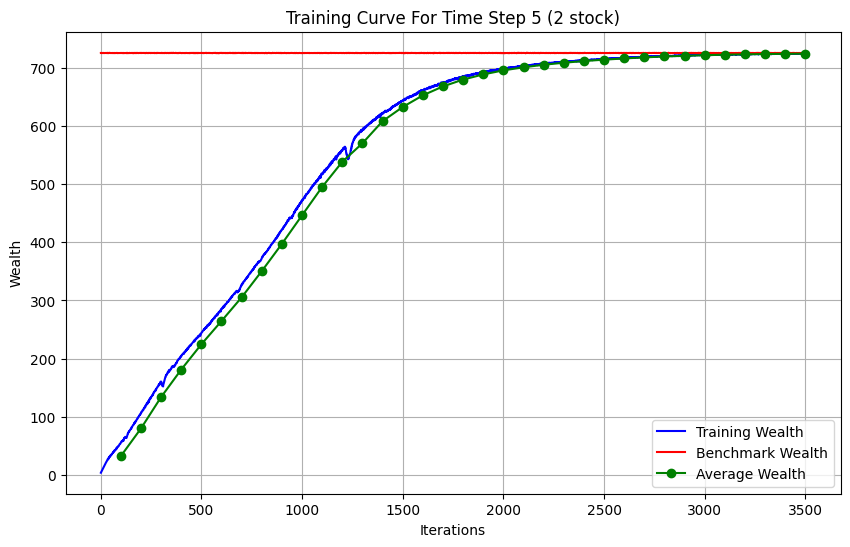

In [126]:
loss_for_plot = np.array(loss_for_plot)
loss_for_plot_benchmark = np.array(loss_for_plot_benchmark)

iterations = np.arange(1,params['batches']+1)  



# Reshape the array into groups of 100 iterations
grouped_losses = loss_for_plot[:params['batches'] - (params['batches'] % 100)].reshape(-1, 100)
average_losses = np.mean(grouped_losses, axis=1)

# Create an array representing the iteration numbers
iteration_numbers = np.arange(100, params['batches'] + 1, 100)


plt.figure(figsize=(10, 6))
plt.plot(iterations, loss_for_plot, label='Training Wealth', color='blue')
## add another line for benchmark loss
plt.plot(iterations, loss_for_plot_benchmark, label='Benchmark Wealth', color='red')
plt.plot(iteration_numbers, average_losses, marker='o', label='Average Wealth', color='green')
plt.xlabel('Iterations')
plt.ylabel('Wealth')
plt.title(f'Training Curve For Time Step {params["time_step"]} ({params["num_stock"]} stock)')
plt.grid(True)
plt.legend()
plt.show()

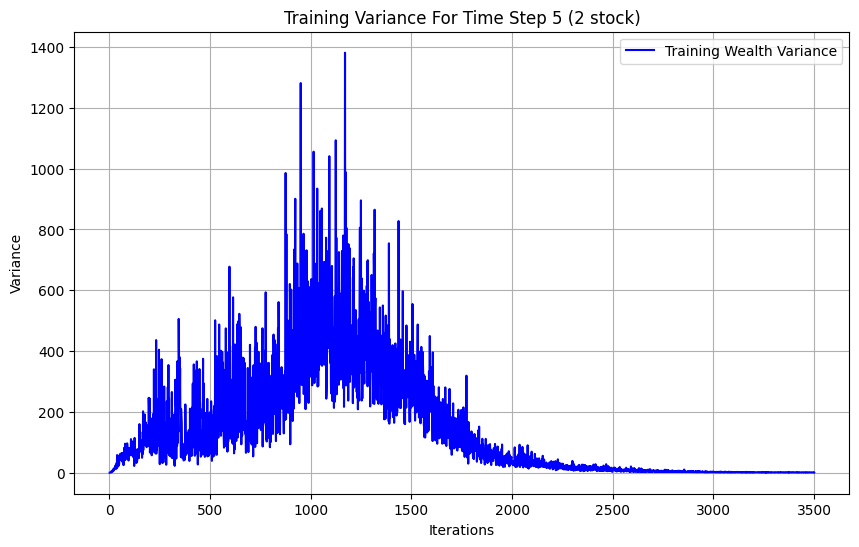

In [127]:
loss_var_for_plot = np.array(loss_var_for_plot)


iterations = np.arange(1,params['batches']+1)  



plt.figure(figsize=(10, 6))
plt.plot(iterations, loss_var_for_plot, label='Training Wealth Variance', color='blue')
## add another line for benchmark loss
plt.xlabel('Iterations')
plt.ylabel('Variance')
plt.title(f'Training Variance For Time Step {params["time_step"]} ({params["num_stock"]} stock)')
plt.grid(True)
plt.legend()
plt.show()

## Save model

In [128]:
## save the model

torch.save(model_simple.state_dict(), f'./checkpoints/OU_2stocks_t5_gamma{params["gamma"]}.pt')


## Load Model (gamma=1)

In [111]:
model_simple.load_state_dict(torch.load('./checkpoints/OU_2stocks_t5_gamma1.pt'))

<All keys matched successfully>

## KDE gamma=1

In [112]:
# generate paths 
state = torch.tensor([[150, 50,50,0, 0,0]]).type(torch.FloatTensor)
# repeat state for batch size
process = 'OU'
time_num = 5

action_for_plot_OU, action_bench_for_plot_OU = simulate_action(params, state, model_simple, model_test, time_num, 12000, process = process)

The time index we are simulating is:  [ 0 10 20 30 40]


In [115]:

mean_action = np.mean(action_for_plot_OU, axis=0)
var_action = np.var(action_for_plot_OU, axis=0)
mean_action_bench = np.mean(action_bench_for_plot_OU, axis=0)
var_action_bench = np.var(action_bench_for_plot_OU, axis=0)

# Print the mean and variance of the action and action bench for each time and group by stock

print("Mean of the action for each time step and stock:")
print(mean_action)
print("\nVariance of the action for each time step and stock:")
print(var_action)

print("\nMean of the action bench for each time step and stock:")
print(mean_action_bench)
print("\nVariance of the action bench for each time step and stock:")
print(var_action_bench)

Mean of the action for each time step and stock:
[[ 3.9544685 50.130188 ]
 [ 4.102868  49.82648  ]
 [ 4.5715203 53.445038 ]
 [ 3.9626565 52.87889  ]
 [ 3.5303411 44.71122  ]]

Variance of the action for each time step and stock:
[[2.49285819e-07 1.33009080e-05]
 [4.46869656e-02 3.50622010e+00]
 [1.43159032e-01 1.41640663e+01]
 [1.08856484e-01 2.19725647e+01]
 [4.73096818e-02 1.24229984e+01]]

Mean of the action bench for each time step and stock:
[[ 4.        49.999996 ]
 [ 3.9999118 50.00408  ]
 [ 4.001262  50.001495 ]
 [ 3.9990697 50.009197 ]
 [ 4.0024495 50.008537 ]]

Variance of the action bench for each time step and stock:
[[0.         0.        ]
 [0.0182613  0.45855466]
 [0.02054911 0.5198347 ]
 [0.02109474 0.52802014]
 [0.02132608 0.5318842 ]]


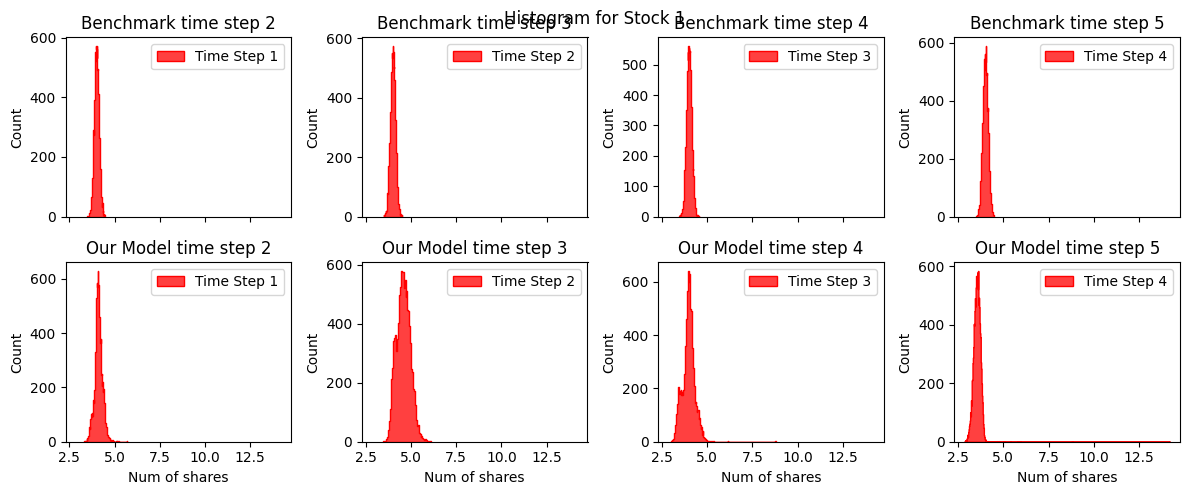

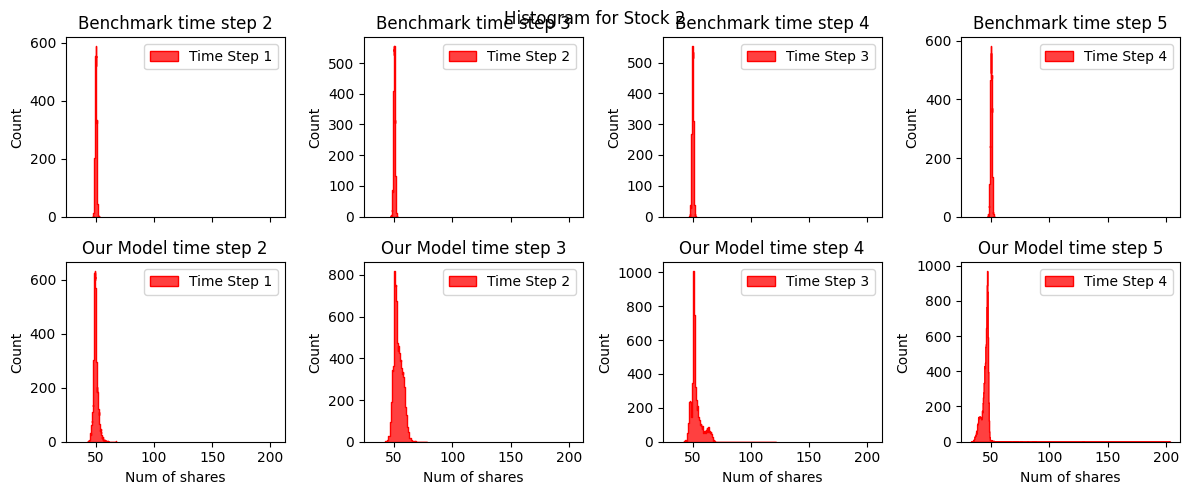

In [113]:
histogram(action_for_plot_OU, action_bench_for_plot_OU)

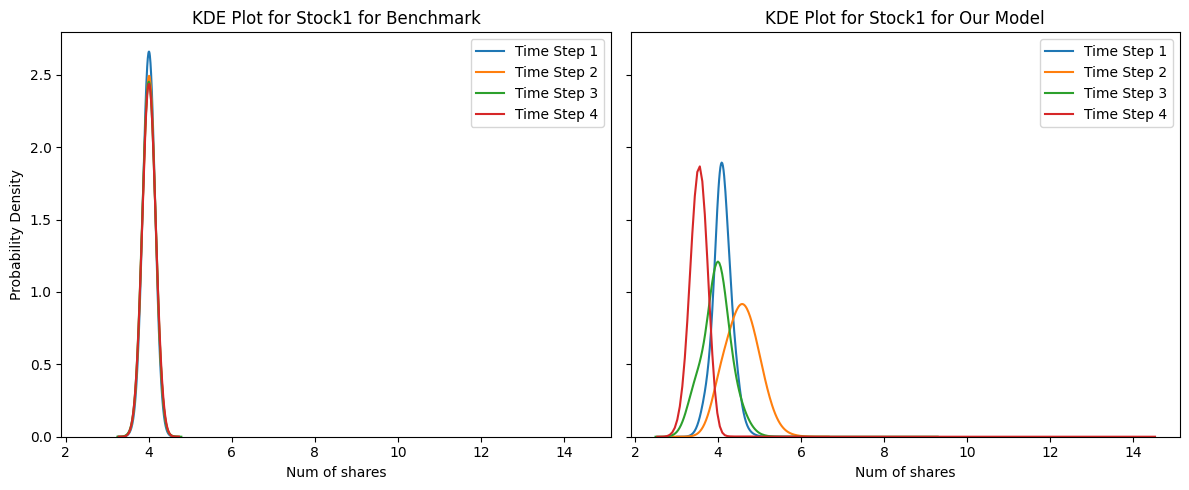

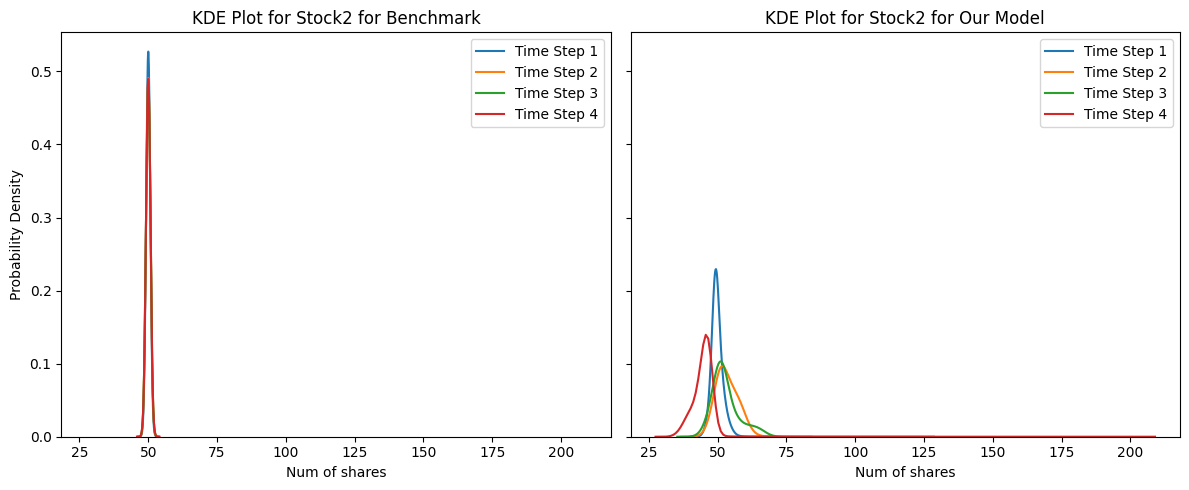

In [114]:
bandwidth=0.5


plot_kde(action_for_plot_OU, action_bench_for_plot_OU, bandwidth=bandwidth)

## Load Model (gamma=3)

In [102]:
## load the model
model_simple.load_state_dict(torch.load('./checkpoints/OU_2stocks_t5_gamma3.pt'))

<All keys matched successfully>

## KDE gamma=3


In [103]:
# generate paths 
state = torch.tensor([[150, 50,50,0, 0,0]]).type(torch.FloatTensor)
# repeat state for batch size
process = 'OU'
time_num = 5

action_for_plot_OU, action_bench_for_plot_OU = simulate_action(params, state, model_simple, model_test, time_num, 20000, process = process)

## use the action, calculate the wealth



The time index we are simulating is:  [ 0 10 20 30 40]


In [108]:




mean_action = np.mean(action_for_plot_OU, axis=0)
var_action = np.var(action_for_plot_OU, axis=0)
mean_action_bench = np.mean(action_bench_for_plot_OU, axis=0)
var_action_bench = np.var(action_bench_for_plot_OU, axis=0)

# Print the mean and variance of the action and action bench for each time and group by stock

print("Mean of the action for each time step and stock:")
print(mean_action)
print("\nVariance of the action for each time step and stock:")
print(var_action)

print("\nMean of the action bench for each time step and stock:")
print(mean_action_bench)
print("\nVariance of the action bench for each time step and stock:")
print(var_action_bench)

Mean of the action for each time step and stock:
[[ 1.3165486 16.646252 ]
 [ 1.225961  16.676365 ]
 [ 1.2360022 15.420183 ]
 [ 1.0926622 15.588569 ]
 [ 1.428531  18.91431  ]]

Variance of the action for each time step and stock:
[[5.2616350e-08 2.9017510e-06]
 [1.5694082e-02 1.3078346e+00]
 [2.8221564e-02 3.3084397e+00]
 [3.1203192e-02 2.8836017e+00]
 [2.5235627e-02 2.5546026e+00]]

Mean of the action bench for each time step and stock:
[[ 1.3335043 16.666079 ]
 [ 1.3337541 16.669275 ]
 [ 1.3336158 16.671787 ]
 [ 1.332256  16.6704   ]
 [ 1.3331184 16.670885 ]]

Variance of the action bench for each time step and stock:
[[2.9220548e-08 3.4506326e-07]
 [1.8419825e-02 4.6057266e-01]
 [2.0716630e-02 5.2363980e-01]
 [2.1105591e-02 5.3050482e-01]
 [2.1059040e-02 5.2099431e-01]]


In [ ]:
init_state = state.repeat(20000, 1).to(device)
market = Market(num_stock = params['num_stock'], num_brownian = params['num_brownian'], batch_size= 20000, process_for_zeta= process, k = params['k'], sig_z = params['sig_z'], dt = params['dt'])
model_simple.set_market_simulator(market)
model_test.set_market_simulator(market)
model_simple.eval()
model_test.eval()



    
action, param = model_simple(init_state)

mu = param['mu']
sigma = param['sigma']
zeta = param['zeta']
bt = param['bt']
lamda = param['lamda']
loss_batch = criterion(action, mu, sigma, zeta, bt,lamda).to(torch.float)
loss_ = torch.mean(loss_batch,dim=0).to(torch.float)
print('The wealth for our model is: ', loss_.item())


action_bench, param = model_test(init_state)


mu = param['mu']
sigma = param['sigma']
zeta = param['zeta']
bt = param['bt']
lamda = param['lamda']
loss_batch = criterion(action_bench, mu, sigma, zeta, bt,lamda).to(torch.float)
loss_bench = torch.mean(loss_batch,dim=0).to(torch.float)
print('The wealth for the benchmark model is: ', loss_bench.item())


for i in range(action.shape[1]):
    print(f"the mean action for stock 1 is {torch.mean(action[:,i,0])}, the mean action for stock 2 is {torch.mean(action[:,i,1])}")
    print(f"the mean benchmark action for stock 1 is {torch.mean(action_bench[:,i,0])}, the mean benchmark action for stock 2 is {torch.mean(action_bench[:,i,1])}")

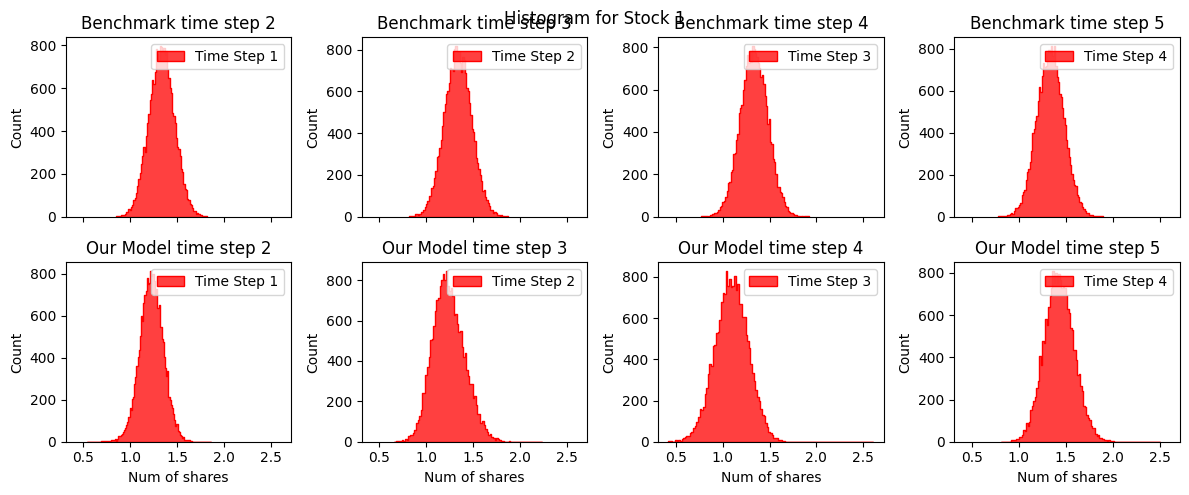

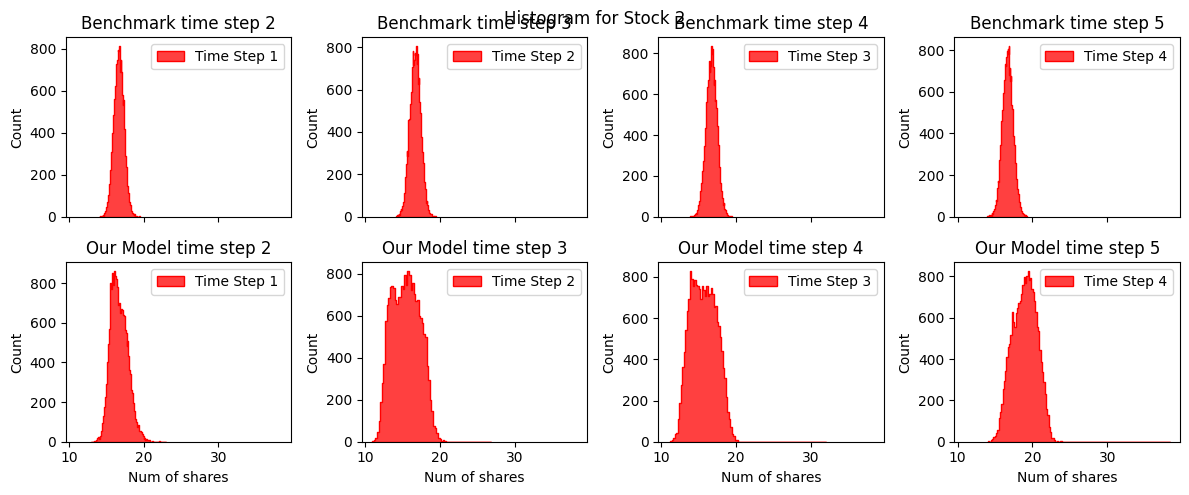

In [105]:
histogram(action_for_plot_OU, action_bench_for_plot_OU)

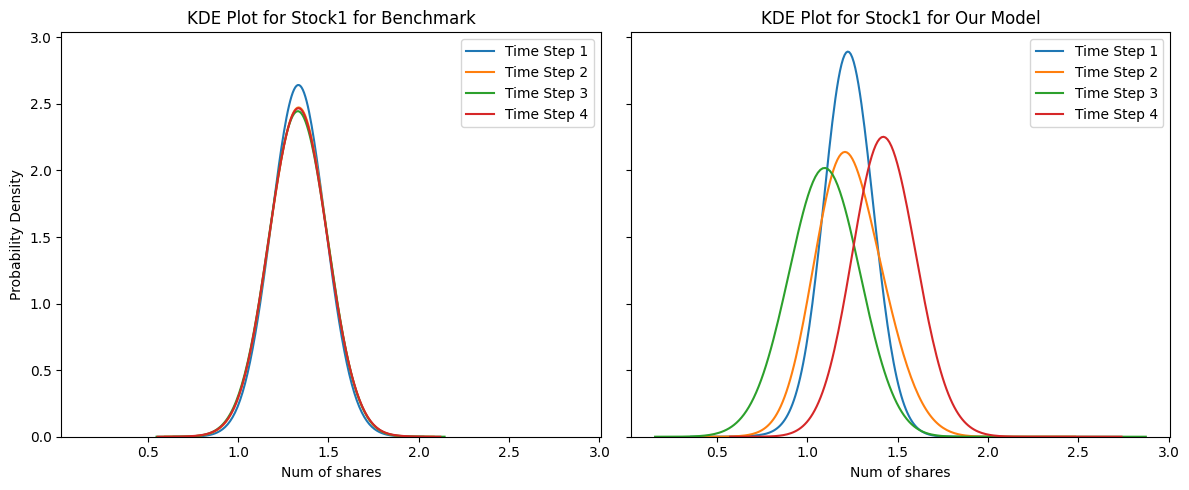

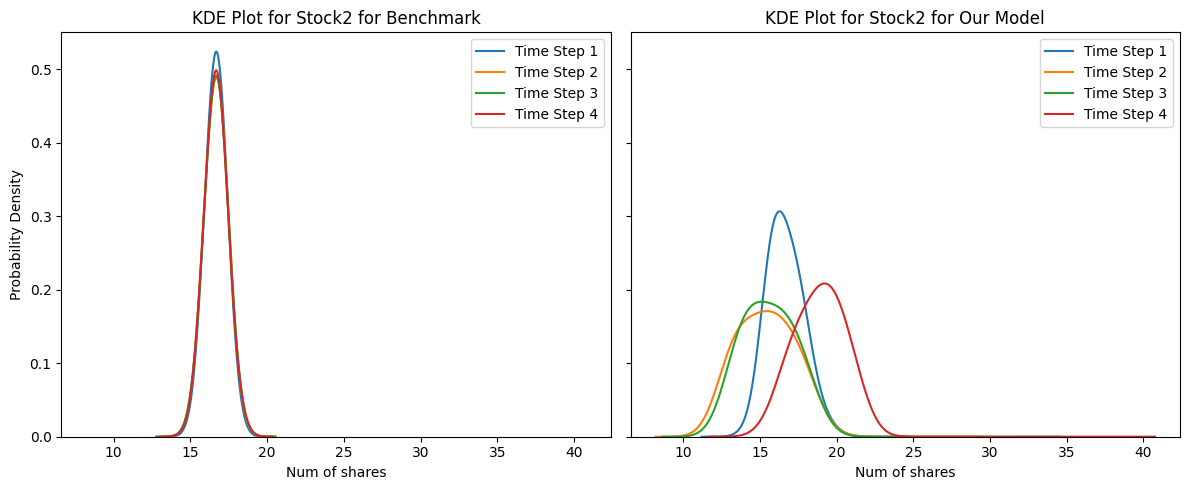

In [106]:
bandwidth=0.5


plot_kde(action_for_plot_OU, action_bench_for_plot_OU, bandwidth=bandwidth)

## Load model (gamma=0.1)


In [129]:
## load the model
model_simple.load_state_dict(torch.load('./checkpoints/OU_2stocks_t5_gamma0.1.pt'))

<All keys matched successfully>

## KDE simulations


In [130]:
# generate paths 
state = torch.tensor([[150, 50,50,0, 0,0]]).type(torch.FloatTensor)
# repeat state for batch size
process = 'OU'
time_num = 5

action_for_plot_OU, action_bench_for_plot_OU = simulate_action(params, state, model_simple, model_test, time_num, 12000, process = process)



The time index we are simulating is:  [ 0 10 20 30 40]


In [131]:
mean_action = np.mean(action_for_plot_OU, axis=0)
var_action = np.var(action_for_plot_OU, axis=0)
mean_action_bench = np.mean(action_bench_for_plot_OU, axis=0)
var_action_bench = np.var(action_bench_for_plot_OU, axis=0)

# Print the mean and variance of the action and action bench for each time and group by stock

print("Mean of the action for each time step and stock:")
print(mean_action)
print("\nVariance of the action for each time step and stock:")
print(var_action)

print("\nMean of the action bench for each time step and stock:")
print(mean_action_bench)
print("\nVariance of the action bench for each time step and stock:")
print(var_action_bench)

Mean of the action for each time step and stock:
[[ 40.34322  498.9974  ]
 [ 42.65457  530.3739  ]
 [ 40.39033  504.42413 ]
 [ 40.796093 505.76987 ]
 [ 40.697327 507.91922 ]]

Variance of the action for each time step and stock:
[[1.0170050e-05 4.7480169e-04]
 [5.2061505e+00 6.3305322e+02]
 [7.0294309e-01 1.3946469e+02]
 [3.8740144e+00 5.3074194e+02]
 [1.6358887e+00 2.2744183e+02]]

Mean of the action bench for each time step and stock:
[[ 40.       499.99997 ]
 [ 39.998737 499.9966  ]
 [ 39.998272 500.0043  ]
 [ 39.99825  499.9974  ]
 [ 39.999157 500.00095 ]]

Variance of the action bench for each time step and stock:
[[0.         0.        ]
 [0.01862155 0.46898344]
 [0.02052166 0.52234596]
 [0.02071939 0.52804613]
 [0.02108395 0.52196693]]


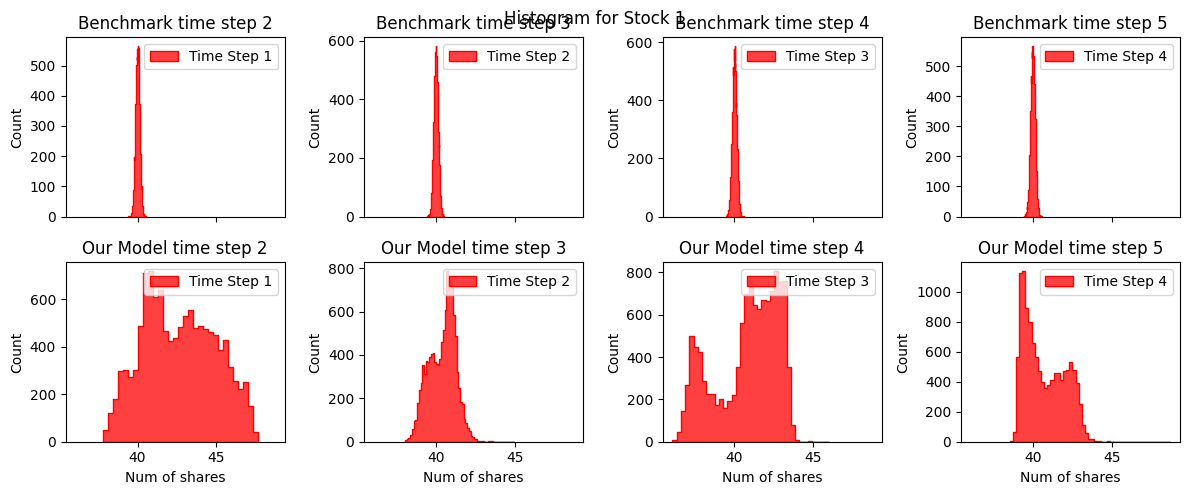

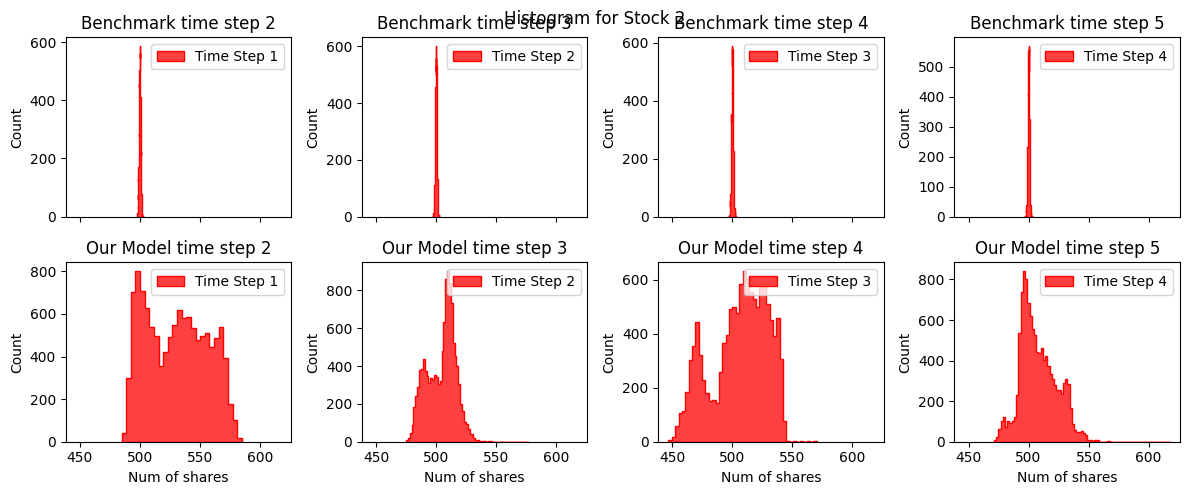

In [132]:
histogram(action_for_plot_OU, action_bench_for_plot_OU)

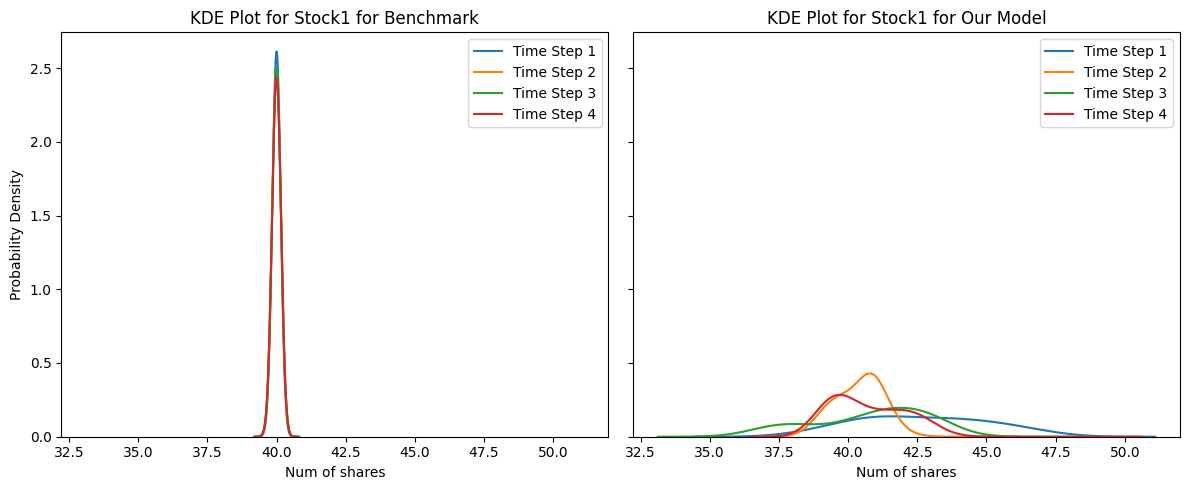

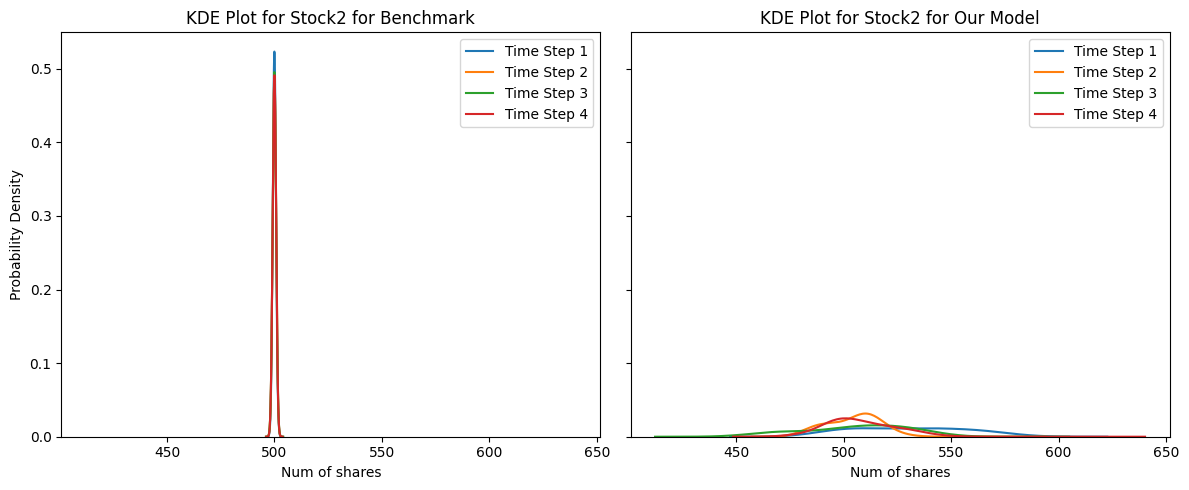

In [133]:
bandwidth=0.5


plot_kde(action_for_plot_OU, action_bench_for_plot_OU, bandwidth=bandwidth)

## Wealth Maximization Problem with 2 stock & Time step=5, Brownian for zeta

In [134]:
params = {"batch_size": 64, 'hidden_size': 100, "lr": 1e-3, "batches": 3000, "time_step": 5, "num_stock": 2, "num_brownian": 3, 'dt': 0.1, 'gamma': 1, 'k':1, 'sig_z':0.1}

mu = torch.tensor([[0.5],[1]]).type(torch.cuda.FloatTensor)
sigma = torch.tensor([[0.1,0,0],[0,0.5,0]]).type(torch.cuda.FloatTensor)
zeta = torch.tensor([[0],[0],[0]]).type(torch.FloatTensor).to(device)

init_param = {'geo_param':(mu,sigma), 'zeta': zeta, 'bt': torch.tensor([0]).type(torch.FloatTensor).to(device)}
state = torch.tensor([[150, 50,50,0, 0,0]]).type(torch.FloatTensor)
# repeat state for batch size
state = state.repeat(params['batch_size'], 1).to(device)
market = Market(num_stock = params['num_stock'], num_brownian = params['num_brownian'], batch_size=params['batch_size'], process_for_zeta='brownian', k = params['k'], sig_z = params['sig_z'], dt = params['dt'])
model_b = WealthMax(market,time_step=params['time_step'], num_brownian=params['num_brownian'], num_stock=params['num_stock'], dt=params['dt'], gamma=params['gamma']).to(device)
model_b.set_init_system_parameter(geo_param = init_param['geo_param'], zeta = init_param['zeta'], bt = init_param['bt'])

model_test_b = AnaSolMaxWealth(market, time_step=params['time_step'], num_brownian=params['num_brownian'], num_stock=params['num_stock'], dt=params['dt'], gamma=params['gamma']).to(device)
model_test_b.set_init_system_parameter(geo_param = init_param['geo_param'], zeta = init_param['zeta'], bt = init_param['bt'])


opt = Adam(model_b.parameters(), lr=params["lr"])
scheduler = ExponentialLR(opt, gamma=0.95)
criterion = Wealth(dt=params['dt'], gamma=params['gamma'])


In [47]:


loss_for_plot, loss_for_plot_benchmark, loss_var_for_plot = train(params, model_b, model_test_b, criterion, opt,  state)

Iteration: 0, Reward: -22.01954460144043
Iteration: 0, Reward_benchmark: 69.44615173339844
Iteration: 100, Reward: 12.51742172241211
Iteration: 100, Reward_benchmark: 70.19586944580078
Iteration: 200, Reward: 27.79806137084961
Iteration: 200, Reward_benchmark: 66.30696868896484
Iteration: 300, Reward: 45.69660949707031
Iteration: 300, Reward_benchmark: 61.814300537109375
Iteration: 400, Reward: 59.686912536621094
Iteration: 400, Reward_benchmark: 64.35204315185547
Iteration: 500, Reward: 64.53465270996094
Iteration: 500, Reward_benchmark: 70.56289672851562
Iteration: 600, Reward: 67.01016998291016
Iteration: 600, Reward_benchmark: 62.694908142089844
Iteration: 700, Reward: 65.6361083984375
Iteration: 700, Reward_benchmark: 62.833988189697266
Iteration: 800, Reward: 59.609596252441406
Iteration: 800, Reward_benchmark: 69.0926513671875
Iteration: 900, Reward: 62.99275207519531
Iteration: 900, Reward_benchmark: 65.86656188964844
Iteration: 1000, Reward: 62.32681655883789
Iteration: 1000, 

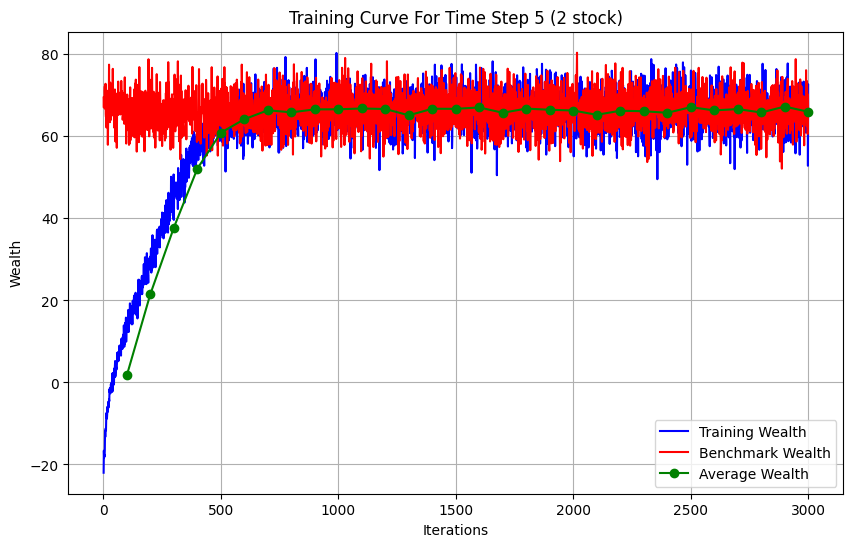

In [48]:
loss_for_plot = np.array(loss_for_plot)
loss_for_plot_benchmark = np.array(loss_for_plot_benchmark)

iterations = np.arange(1,params['batches']+1)  



# Reshape the array into groups of 100 iterations
grouped_losses = loss_for_plot[:params['batches'] - (params['batches'] % 100)].reshape(-1, 100)
average_losses = np.mean(grouped_losses, axis=1)

# Create an array representing the iteration numbers
iteration_numbers = np.arange(100, params['batches']+1, 100)


plt.figure(figsize=(10, 6))
plt.plot(iterations, loss_for_plot, label='Training Wealth', color='blue')
## add another line for benchmark loss
plt.plot(iterations, loss_for_plot_benchmark, label='Benchmark Wealth', color='red')
plt.plot(iteration_numbers, average_losses, marker='o', label='Average Wealth', color='green')
plt.xlabel('Iterations')
plt.ylabel('Wealth')
plt.title(f'Training Curve For Time Step {params["time_step"]} ({params["num_stock"]} stock)')
plt.grid(True)
plt.legend()
plt.show()

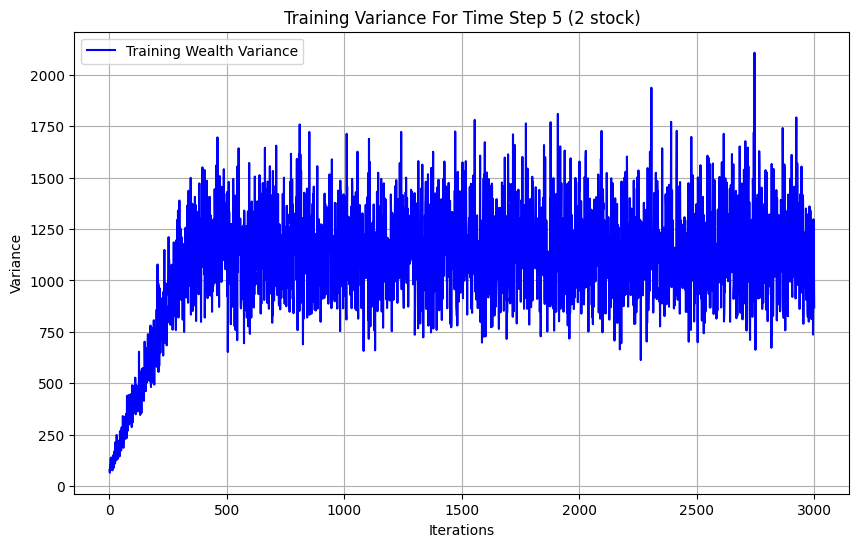

In [49]:
loss_var_for_plot = np.array(loss_var_for_plot)


iterations = np.arange(1,params['batches']+1)  



plt.figure(figsize=(10, 6))
plt.plot(iterations, loss_var_for_plot, label='Training Wealth Variance', color='blue')
## add another line for benchmark loss
plt.xlabel('Iterations')
plt.ylabel('Variance')
plt.title(f'Training Variance For Time Step {params["time_step"]} ({params["num_stock"]} stock)')
plt.grid(True)
plt.legend()
plt.show()

## Testing with whether the last time step got counted into training

In [105]:
state = torch.tensor([[150, 50,50,0, 0,0]]).type(torch.FloatTensor)
# repeat state for batch size
state = state.repeat(64, 1).to(device)
criterion = Wealth(dt=params['dt'])
model_b.eval()
model_test_b.eval()

action, param = model_b(state)
action_t, param_t = model_test_b(state)

print(f'The action for the last time step for stock 2 is :{action[:,4,1]}')
print(f'The action for the last time step for stock 1 is :{action[:,4,0]}, mean is {torch.mean(action[:,4,0])} and std is {torch.std(action[:,4,0])}')

mu = param['mu']
sigma = param['sigma']
zeta = param['zeta']
bt = param['bt']
lamda = param['lamda']

mu_t = param_t['mu']
sigma_t = param_t['sigma']
zeta_t = param_t['zeta']
bt_t = param_t['bt']
lamda_t = param_t['lamda']



# for j in range(lamda.shape[0]):
#     if lamda[j,:] != 0:
#         print(f'iteration {i}, batch {j+1} lambda is not zero')
#         print(lamda[i,:])


loss_batch = criterion(action, mu, sigma, zeta, bt,lamda).to(torch.float)
print(torch.mean(loss_batch).item())


print(f'The benchmark action for the last time step for stock 2 is :{action_t[:,4,1]}')
print(f'The benchmark action for the last time step for stock 1 is :{action_t[:,4,0]}, mean is {torch.mean(action_t[:,4,0])} and std is {torch.std(action_t[:,4,0])}')
loss_batch_t = criterion(action_t, mu_t, sigma_t, zeta_t, bt_t,lamda_t).to(torch.float)
print(torch.mean(loss_batch_t).item())


The action for the last time step for stock 2 is :tensor([ 966.9435,  999.5589,  986.3015,  931.4746,  902.6383, 1003.3073,
         942.1234, 1005.4183, 1011.5712, 1018.6749,  952.0441,  941.2335,
         954.4753, 1024.4620,  927.8942,  939.3829, 1004.7771,  955.4210,
        1005.1981, 1041.0149,  947.8378,  937.7560,  998.1499,  953.9502,
        1003.1622, 1033.0588,  958.0756,  979.3058,  922.9517,  964.8307,
         984.5776, 1008.0566,  925.3070,  910.6506, 1000.1833, 1007.7979,
         943.8792, 1005.9623,  897.8895,  990.2055, 1007.5266,  923.4855,
         892.3086, 1009.4521,  993.0944,  977.7181,  914.2185,  930.6708,
        1022.4719,  970.6757, 1030.3334, 1027.3268,  985.7275,  936.8127,
         981.6841,  968.4220, 1021.6005,  936.0048,  948.8148,  938.7100,
         983.8915,  986.6904,  994.0415,  921.7341], device='cuda:0',
       grad_fn=<SelectBackward0>)
The action for the last time step for stock 1 is :tensor([13.2908, 11.4855, 12.2016, 14.5751, 12.4678, 11.

## Untrained

In [19]:
params = {"batch_size": 64, 'hidden_size': 100, "lr": 1e-3, "batches": 3500, "time_step": 5, "num_stock": 2, "num_brownian": 3, 'dt': 1, 'gamma': 5,'k':1, 'sig_z':0.1}

mu = torch.tensor([[0],[1]]).type(torch.cuda.FloatTensor)
sigma = torch.tensor([[1,0,0],[0,0.1,0]]).type(torch.cuda.FloatTensor)
zeta = torch.tensor([[0],[0],[0]]).type(torch.FloatTensor).to(device)

init_param = {'geo_param':(mu,sigma), 'zeta': zeta, 'bt': torch.tensor([0]).type(torch.FloatTensor).to(device)}
state = torch.tensor([[150, 50,50,0, 0,0]]).type(torch.FloatTensor)
# repeat state for batch size
state = state.repeat(params['batch_size'], 1).to(device)
market = Market(num_stock = params['num_stock'], num_brownian = params['num_brownian'], batch_size=params['batch_size'], process_for_zeta='brownian', k = params['k'], sig_z = params['sig_z'])
model_raw = WealthMax(market,time_step=params['time_step'], num_brownian=params['num_brownian'], num_stock=params['num_stock'], dt=params['dt']).to(device)
model_raw.set_init_system_parameter(geo_param = init_param['geo_param'], zeta = init_param['zeta'], bt = init_param['bt'])

In [20]:
state = torch.tensor([[150, 50,50,0, 0,0]]).type(torch.FloatTensor)
# repeat state for batch size
state = state.repeat(64, 1).to(device)

model_raw.eval()
model_test_b.eval()

action, param = model_raw(state)
action_t, param_t = model_test_b(state)

print(f'The action for the last time step for stock 2 is :{action[:,4,1]}')
print(f'The action for the last time step for stock 1 is :{action[:,4,0]}, mean is {torch.mean(action[:,4,0])} and std is {torch.std(action[:,4,0])}')

mu = param['mu']
sigma = param['sigma']
zeta = param['zeta']
bt = param['bt']
lamda = param['lamda']



# for j in range(lamda.shape[0]):
#     if lamda[j,:] != 0:
#         print(f'iteration {i}, batch {j+1} lambda is not zero')
#         print(lamda[i,:])


loss_batch = criterion(action, mu, sigma, zeta, bt,lamda).to(torch.float)
print(torch.mean(loss_batch).item())

The action for the last time step for stock 2 is :tensor([35.0773, 18.6304, 35.4730, 15.9485, 38.2792, 42.4108, 37.7893, 15.5677,
        11.3428, 40.0801, 24.5160, 16.7998, 45.6596, 32.0562, 38.3158, 22.0027,
        43.2276, 25.5365, 14.9541, 14.9745, 25.6090, 25.1545, 46.2056, 27.3496,
        12.5196, 17.0691, 57.8827, 51.3307, 13.0889, 27.4563, 47.9244, 30.7470,
        51.0191, 21.5674, 15.1632, 39.1575, 22.9947, 26.7858, 45.1252, 70.9380,
        40.6085, 41.1580, 26.4510, 19.5582, 30.7319, 16.1614, 23.6644, 34.2200,
        32.7854, 33.5592, 19.6467, 32.0549, 30.6201, 11.9253, 17.9503, 24.2093,
        28.9949, 20.0274, 26.5499, 32.7416, 55.8932, 23.0901, 46.1472, 53.0280],
       device='cuda:0', grad_fn=<SelectBackward0>)
The action for the last time step for stock 1 is :tensor([20.6961,  9.8921, 19.7372,  8.1634, 22.3530, 23.4095, 21.1091,  6.7586,
         3.6358, 22.0632, 14.8485,  6.3875, 25.3824, 19.8440, 21.6298, 12.3523,
        22.8957, 16.4373,  6.6344,  6.1769, 15.0

## Save Model

In [63]:
## save the model

torch.save(model_b.state_dict(), f'./checkpoints/BW_2stocks_t5_gamma{params["gamma"]}.pt')

## Load Model


In [135]:
## load the model
model_b.load_state_dict(torch.load('./checkpoints/BW_2stocks_t5_gamma1.pt'))

<All keys matched successfully>

## Simulations for KDE plot


In [142]:


# generate paths 
state = torch.tensor([[150, 50,50,0, 0,0]]).type(torch.FloatTensor)
# repeat state for batch size
process = 'brownian'
time_num = 5

action_for_plot_b, action_bench_for_plot_b = simulate_action(params, state, model_b, model_test_b, time_num, 12000, process = process)










The time index we are simulating is:  [ 0 10 20 30 40]


In [143]:
mean_action = np.mean(action_for_plot_b, axis=0)
var_action = np.var(action_for_plot_b, axis=0)
mean_action_bench = np.mean(action_bench_for_plot_b, axis=0)
var_action_bench = np.var(action_bench_for_plot_b, axis=0)

# Print the mean and variance of the action and action bench for each time and group by stock

print("Mean of the action for each time step and stock:")
print(mean_action)
print("\nVariance of the action for each time step and stock:")
print(var_action)

print("\nMean of the action bench for each time step and stock:")
print(mean_action_bench)
print("\nVariance of the action bench for each time step and stock:")
print(var_action_bench)

Mean of the action for each time step and stock:
[[49.839863   4.0129685]
 [51.513443   3.958437 ]
 [51.216328   4.036349 ]
 [49.764797   3.6328962]
 [50.203156   3.6352587]]

Variance of the action for each time step and stock:
[[9.0822250e-06 9.0807212e-08]
 [8.3555534e+01 3.2138119e+00]
 [1.9599937e+02 7.2521510e+00]
 [3.0532513e+02 1.0400239e+01]
 [3.7489505e+02 1.4752117e+01]]

Mean of the action bench for each time step and stock:
[[49.999996   4.       ]
 [49.838      4.007141 ]
 [49.843433   3.999084 ]
 [49.81674    4.022344 ]
 [49.82251    4.0014567]]

Variance of the action bench for each time step and stock:
[[  0.         0.      ]
 [ 89.79442    3.64405 ]
 [191.00638    7.609534]
 [293.1742    11.655375]
 [393.67496   15.579002]]


## Histograms

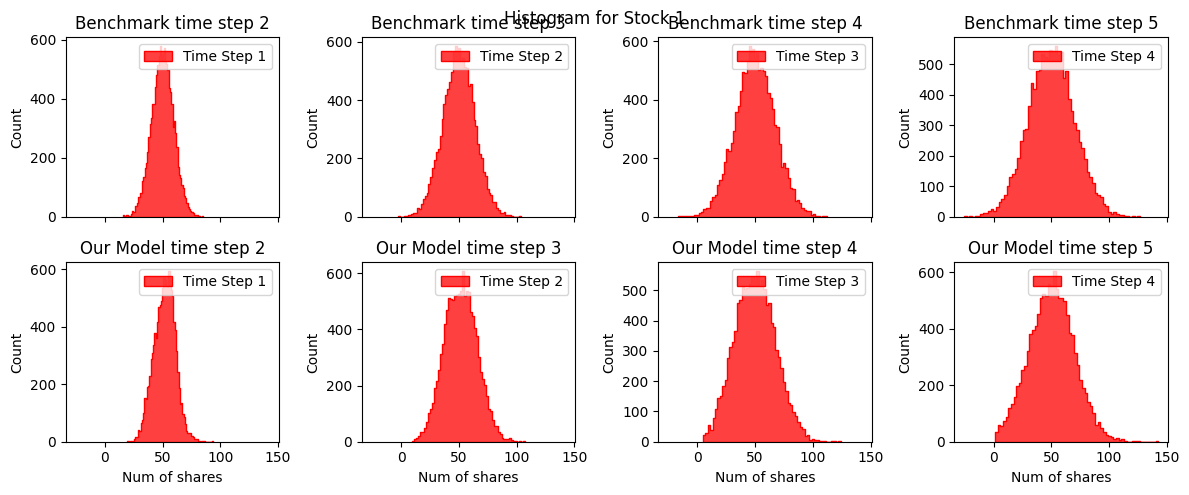

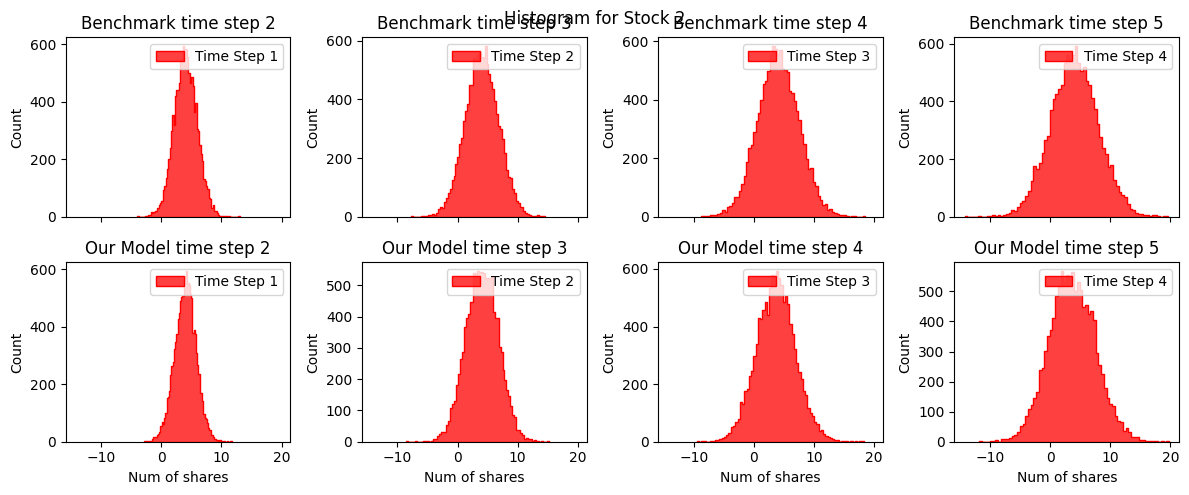

In [144]:
histogram(action_for_plot_b, action_bench_for_plot_b)

## KDEs gamma = 1

## Kernal Density Estimations for 2 stocks, Timestep = 5



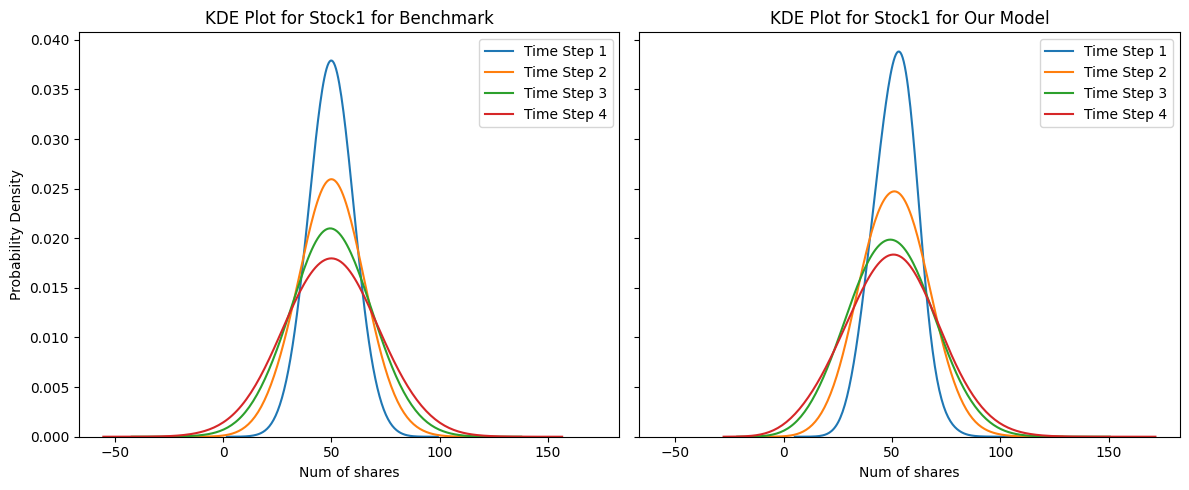

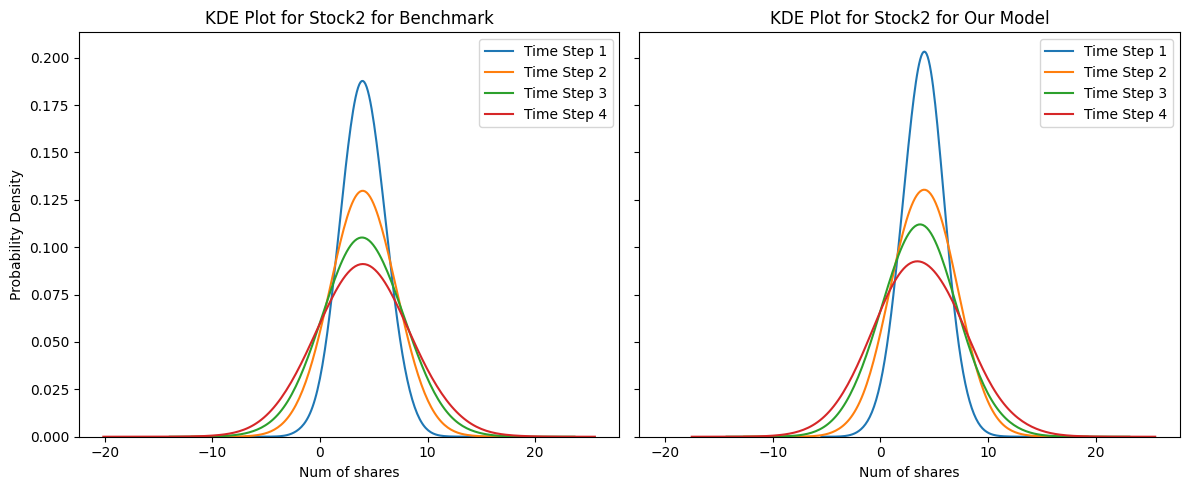

In [145]:
# plot some 

bandwidth=0.5


plot_kde(action_for_plot_b, action_bench_for_plot_b, bandwidth=bandwidth)


## With lowerbound of the drift term (One stock setting) with Brownian

In [96]:
params = {"batch_size": 128, 'hidden_size': 100, "lr": 1e-3, "batches": 1000, "time_step": 5, "num_stock": 1, "num_brownian": 1, 'dt': 0.1, 'k':1, 'sig_z':0.1, 'ce': 100, 'gamma': 1}


mu = torch.tensor([[1]]).type(torch.cuda.FloatTensor)
sigma = torch.tensor([0.5]).type(torch.cuda.FloatTensor)
zeta = torch.tensor([[0]]).type(torch.FloatTensor).to(device)



init_param = {'geo_param':(mu,sigma), 'zeta': zeta, 'bt': torch.tensor([100]).type(torch.FloatTensor).to(device)}
state = torch.tensor([[2000, 10, 0]]).type(torch.FloatTensor)
# repeat state for batch size
state = state.repeat(params['batch_size'], 1).to(device)
market = Market(num_stock = params['num_stock'], num_brownian = params['num_brownian'], batch_size=params['batch_size'], process_for_zeta='brownian', k = params['k'], sig_z = params['sig_z'], dt = params['dt'])
model_cons_b = WealthMax(market,time_step=params['time_step'], num_brownian=params['num_brownian'], num_stock=params['num_stock'], dt=params['dt'], drift_constraint=params['ce'], gamma=params['gamma']).to(device)
model_cons_b.set_init_system_parameter(geo_param = init_param['geo_param'], zeta = init_param['zeta'], bt = init_param['bt'])

model_test_con_b = AnaSolMaxWealth_driftcon(market, time_step=params['time_step'], num_brownian=params['num_brownian'], num_stock=params['num_stock'], dt=params['dt'], drift_constraint=params['ce'], gamma=params['gamma']).to(device)
model_test_con_b.set_init_system_parameter(geo_param = init_param['geo_param'], zeta = init_param['zeta'], bt = init_param['bt'])

opt = Adam(model_cons_b.parameters(), lr=params["lr"])
criterion = Wealth(dt=params['dt'], drift_constraint=params['ce'], gamma=params['gamma'])

In [97]:
loss_for_plot, loss_for_plot_benchmark, loss_var_for_plot= train(params, model_cons_b, model_test_con_b, criterion, opt, state)

Iteration: 0, Reward: 493.9189147949219
Iteration: 0, Reward_benchmark: 510.22149658203125
Iteration: 100, Reward: 509.00286865234375
Iteration: 100, Reward_benchmark: 509.8056640625
Iteration: 200, Reward: 509.3381652832031
Iteration: 200, Reward_benchmark: 509.1313781738281
Iteration: 300, Reward: 510.2751770019531
Iteration: 300, Reward_benchmark: 509.3172302246094
Iteration: 400, Reward: 511.0591735839844
Iteration: 400, Reward_benchmark: 508.0960998535156
Iteration: 500, Reward: 508.38055419921875
Iteration: 500, Reward_benchmark: 508.7724609375
Iteration: 600, Reward: 508.8240966796875
Iteration: 600, Reward_benchmark: 509.045166015625
Iteration: 700, Reward: 507.06854248046875
Iteration: 700, Reward_benchmark: 509.51336669921875
Iteration: 800, Reward: 508.2710876464844
Iteration: 800, Reward_benchmark: 511.984130859375
Iteration: 900, Reward: 509.02545166015625
Iteration: 900, Reward_benchmark: 508.8392333984375


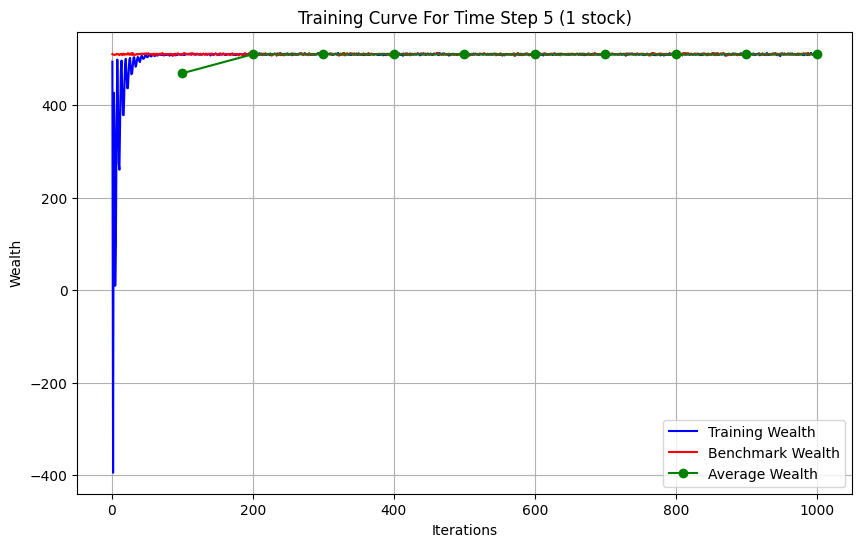

In [100]:
loss_for_plot = np.array(loss_for_plot)
loss_for_plot_benchmark = np.array(loss_for_plot_benchmark)

iterations = np.arange(1,params['batches']+1)  



# Reshape the array into groups of 100 iterations
grouped_losses = loss_for_plot[:params['batches'] - (params['batches'] % 100)].reshape(-1, 100)
average_losses = np.mean(grouped_losses, axis=1)

# Create an array representing the iteration numbers
iteration_numbers = np.arange(100, params['batches']+1, 100)


plt.figure(figsize=(10, 6))
plt.plot(iterations, loss_for_plot, label='Training Wealth', color='blue')
## add another line for benchmark loss
plt.plot(iterations, loss_for_plot_benchmark, label='Benchmark Wealth', color='red')
plt.plot(iteration_numbers, average_losses, marker='o', label='Average Wealth', color='green')
plt.xlabel('Iterations')
plt.ylabel('Wealth')
plt.title(f'Training Curve For Time Step {params["time_step"]} ({params["num_stock"]} stock)')
plt.grid(True)
plt.legend()
plt.show()

## Variance


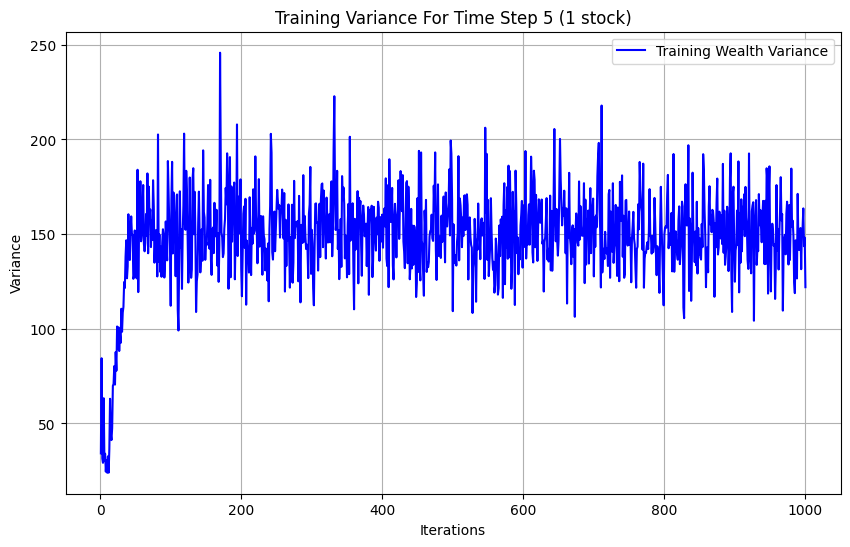

In [101]:
loss_var_for_plot = np.array(loss_var_for_plot)


iterations = np.arange(1,params['batches']+1)  



plt.figure(figsize=(10, 6))
plt.plot(iterations, loss_var_for_plot, label='Training Wealth Variance', color='blue')
## add another line for benchmark loss
plt.xlabel('Iterations')
plt.ylabel('Variance')
plt.title(f'Training Variance For Time Step {params["time_step"]} ({params["num_stock"]} stock)')
plt.grid(True)
plt.legend()
plt.show()

## Save model


In [111]:
torch.save(model_cons_b.state_dict(), './checkpoints/BW_1stock_t5_con.pt')

## Load model


In [12]:
## load the model
model_cons_b.load_state_dict(torch.load('./checkpoints/BW_1stock_t5_con.pt'))

<All keys matched successfully>

## Histograms for wealth


42391.49609375


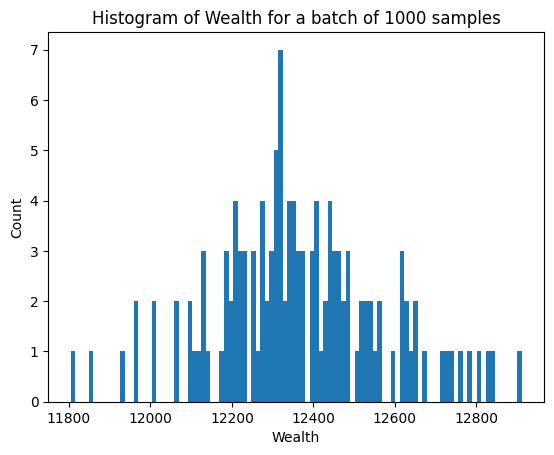

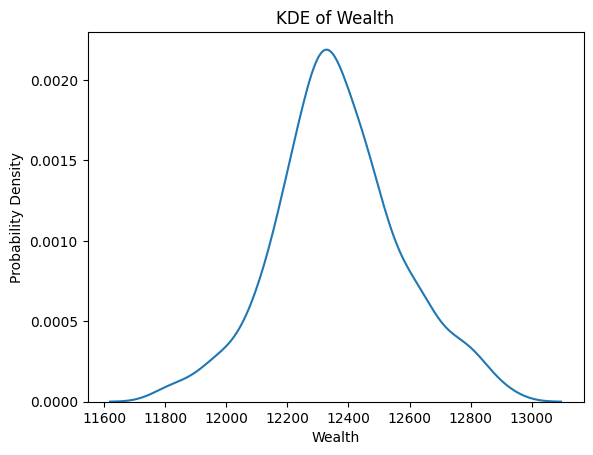

In [13]:
num_simulations = 1000
state = torch.tensor([[2000, 10, 0]]).type(torch.FloatTensor)
# repeat state for batch size
state = state.repeat(128, 1).to(device)
criterion = Wealth(dt=1, drift_constraint=2000)


model_cons_b.eval()

with torch.no_grad():
    action, params = model_cons_b(state)
    mu = params['mu']
    sigma = params['sigma']
    zeta = params['zeta']
    bt = params['bt']
    lamda = params['lamda']

    
    
    # for j in range(lamda.shape[0]):
    #     if lamda[j,:] != 0:
    #         print(f'iteration {i}, batch {j+1} lambda is not zero')
    #         print(lamda[i,:])


    loss_batch = criterion(action, mu, sigma, zeta, bt,lamda).to(torch.float)

    print(torch.var(loss_batch).item())
    # plot the histogram of the loss
    plt.hist(loss_batch.cpu().numpy(), bins=100)
    plt.title(f'Histogram of Wealth for a batch of {num_simulations} samples')
    plt.xlabel('Wealth')
    plt.ylabel('Count')

    # plot the kde of the loss as a separate image
    plt.figure()
    sn.kdeplot(loss_batch.cpu().numpy(), bw_method= 0.3, label='KDE')
    plt.title('KDE of Wealth')
    plt.xlabel('Wealth')
    plt.ylabel('Probability Density')

    

## HISTOGRAMS & KDES

In [108]:
# generate paths
state = torch.tensor([[2000, 10, 0]]).type(torch.FloatTensor)
# generate paths 
# repeat state for batch size
process = 'brownian'
time_num = 6

actions_constraint_B, actions_bench_constraint_B = simulate_action(params, state, model_cons_b, model_test_con_b, time_num, 12000, process = process)

The time index we are simulating is:  [ 0  6 12 18 24 30 36 42 48]


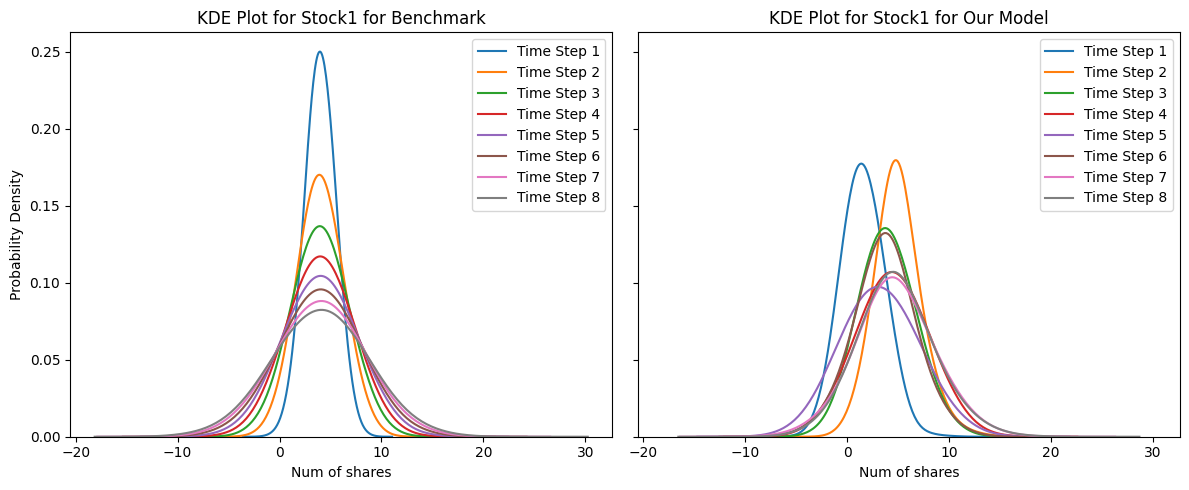

In [109]:
bandwidth=0.5


plot_kde(actions_constraint_B, actions_bench_constraint_B, bandwidth=bandwidth)

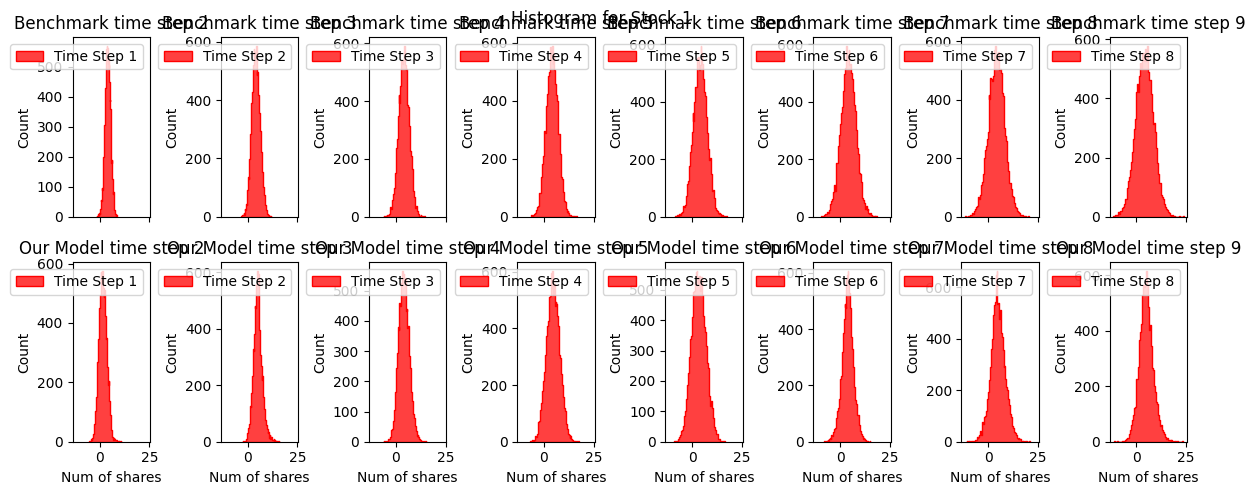

In [110]:
histogram(actions_constraint_B, actions_bench_constraint_B)

## With lowerbound of the drift term (One stock setting) with OU

In [11]:
params = {"batch_size": 128, 'hidden_size': 100, "lr": 1e-3, "batches": 3500, "time_step": 5, "num_stock": 1, "num_brownian": 1, 'dt': 0.1, 'k':1, 'sig_z':0.1, 'ce': 100, 'gamma': 1}


mu = torch.tensor([[1]]).type(torch.cuda.FloatTensor)
sigma = torch.tensor([0.1]).type(torch.cuda.FloatTensor)
zeta = torch.tensor([[0]]).type(torch.FloatTensor).to(device)



init_param = {'geo_param':(mu,sigma), 'zeta': zeta, 'bt': torch.tensor([100]).type(torch.FloatTensor).to(device)}
state = torch.tensor([[2000, 10, 0]]).type(torch.FloatTensor)
# repeat state for batch size
state = state.repeat(params['batch_size'], 1).to(device)
market = Market(num_stock = params['num_stock'], num_brownian = params['num_brownian'], batch_size=params['batch_size'], process_for_zeta='OU', k = params['k'], sig_z = params['sig_z'])
model_cons_OU = WealthMax(market,time_step=params['time_step'], num_brownian=params['num_brownian'], num_stock=params['num_stock'], dt=params['dt'], drift_constraint=params['ce'], gamma=params['gamma']).to(device)
model_cons_OU.set_init_system_parameter(geo_param = init_param['geo_param'], zeta = init_param['zeta'], bt = init_param['bt'])

model_test_con_OU = AnaSolMaxWealth_driftcon(market, time_step=params['time_step'], num_brownian=params['num_brownian'], num_stock=params['num_stock'], dt=params['dt'], drift_constraint=params['ce'], gamma=params['gamma']).to(device)
model_test_con_OU.set_init_system_parameter(geo_param = init_param['geo_param'], zeta = init_param['zeta'], bt = init_param['bt'])

opt = Adam(model_cons_OU.parameters(), lr=params["lr"])
criterion = Wealth(dt=params['dt'], drift_constraint=params['ce'], gamma=params['gamma'])

In [12]:
loss_for_plot, loss_for_plot_benchmark, loss_var_for_plot= train(params, model_cons_OU, model_test_con_OU, criterion, opt, state)

Iteration: 0, Reward: 62.89529037475586
Iteration: 0, Reward_benchmark: 750.0389404296875
Iteration: 100, Reward: 535.1237182617188
Iteration: 100, Reward_benchmark: 750.0872192382812
Iteration: 200, Reward: 571.1629638671875
Iteration: 200, Reward_benchmark: 750.0189819335938
Iteration: 300, Reward: 615.914306640625
Iteration: 300, Reward_benchmark: 750.03515625
Iteration: 400, Reward: 662.0758056640625
Iteration: 400, Reward_benchmark: 749.8939208984375
Iteration: 500, Reward: 696.4583129882812
Iteration: 500, Reward_benchmark: 750.014404296875
Iteration: 600, Reward: 724.7625732421875
Iteration: 600, Reward_benchmark: 749.903564453125
Iteration: 700, Reward: 733.21630859375
Iteration: 700, Reward_benchmark: 750.0991821289062
Iteration: 800, Reward: 744.4232177734375
Iteration: 800, Reward_benchmark: 750.0961303710938
Iteration: 900, Reward: 746.40478515625
Iteration: 900, Reward_benchmark: 749.8997802734375
Iteration: 1000, Reward: 746.935546875
Iteration: 1000, Reward_benchmark: 74

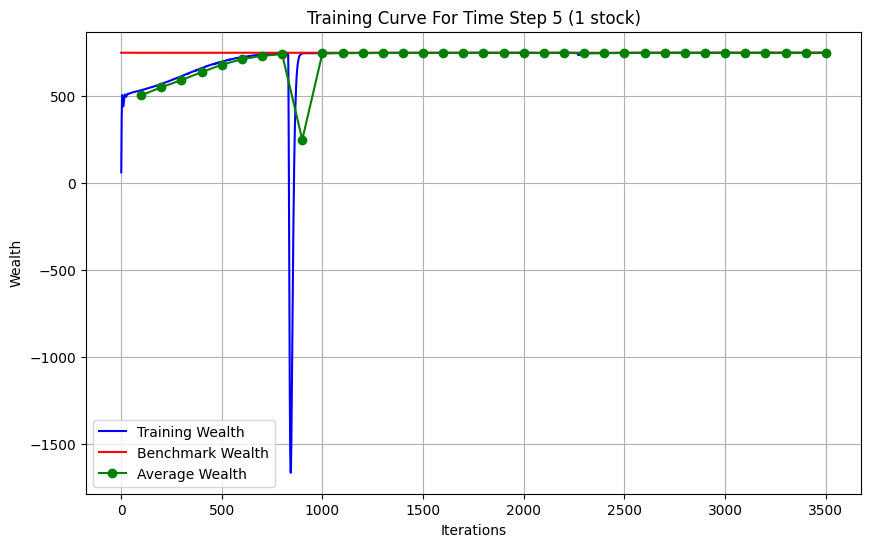

In [13]:
loss_for_plot = np.array(loss_for_plot)
loss_for_plot_benchmark = np.array(loss_for_plot_benchmark)

iterations = np.arange(1,params['batches']+1)  



# Reshape the array into groups of 100 iterations
grouped_losses = loss_for_plot[:params['batches'] - (params['batches'] % 100)].reshape(-1, 100)
average_losses = np.mean(grouped_losses, axis=1)

# Create an array representing the iteration numbers
iteration_numbers = np.arange(100, params['batches'] + 1, 100)


plt.figure(figsize=(10, 6))
plt.plot(iterations, loss_for_plot, label='Training Wealth', color='blue')
## add another line for benchmark loss
plt.plot(iterations, loss_for_plot_benchmark, label='Benchmark Wealth', color='red')
plt.plot(iteration_numbers, average_losses, marker='o', label='Average Wealth', color='green')
plt.xlabel('Iterations')
plt.ylabel('Wealth')
plt.title(f'Training Curve For Time Step {params["time_step"]} ({params["num_stock"]} stock)')
plt.grid(True)
plt.legend()
plt.show()

## Variance


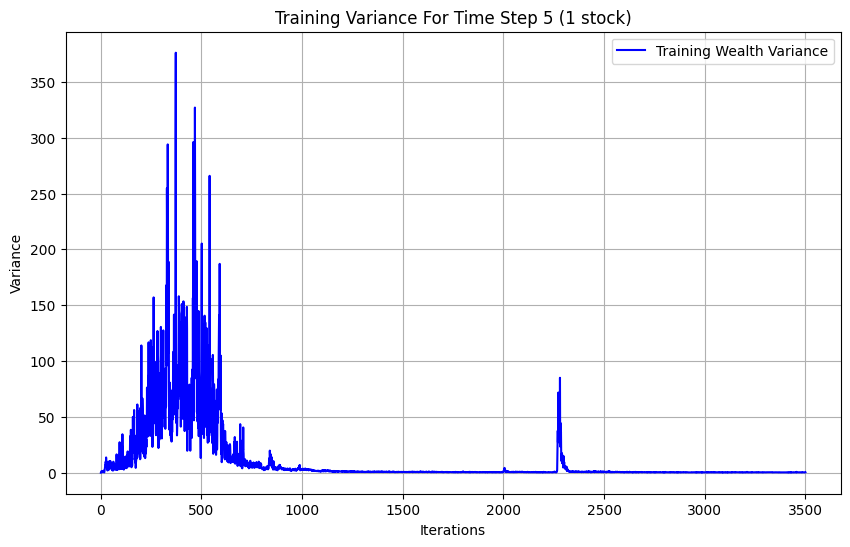

In [14]:
loss_var_for_plot = np.array(loss_var_for_plot)


iterations = np.arange(1,params['batches'] + 1)  



plt.figure(figsize=(10, 6))
plt.plot(iterations, loss_var_for_plot, label='Training Wealth Variance', color='blue')
## add another line for benchmark loss
plt.xlabel('Iterations')
plt.ylabel('Variance')
plt.title(f'Training Variance For Time Step {params["time_step"]} ({params["num_stock"]} stock)')
plt.grid(True)
plt.legend()
plt.show()

## Save Model


In [28]:
## save the model
torch.save(model_cons_OU.state_dict(), './checkpoints/OU_1stock_t5_con.pt')

## Load Model


In [29]:
## load the model
model_cons_b.load_state_dict(torch.load('./checkpoints/OU_1stock_t5_con.pt'))

<All keys matched successfully>

## HISTOGRAMS & KDES

In [25]:
# generate paths 
state = torch.tensor([[2000, 10, 0]]).type(torch.FloatTensor)


process = 'OU'
time_num = 5

actions_constraint_OU, actions_bench_constraint_OU = simulate_action(params, state, model_cons_OU, model_test_con_OU, time_num, 12000, process = process)

The time index we are simulating is:  [ 0 10 20 30 40]


In [24]:
# mean and variance of the actions, for each time step, compared with the benchmark

for i in range(actions_constraint_OU.shape[1]):
    print(f'The mean of the actions for the {i+1} time step for stock 1 is :{np.mean(actions_constraint_OU[:,i,0])} and the variance is {np.var(actions_constraint_OU[:,i,0])}')
    

    print(f'The mean of the benchmark actions for the {i+1} time step for stock 1 is :{np.mean(actions_bench_constraint_OU[:,i,0])} and the variance is {np.var(actions_bench_constraint_OU[:,i,0])}')
    
          


The mean of the actions for the 1 time step for stock 1 is :100.28624725341797 and the variance is 2.3283064365386963e-10
The mean of the benchmark actions for the 1 time step for stock 1 is :99.99999237060547 and the variance is 0.0
The mean of the actions for the 2 time step for stock 1 is :120.51945495605469 and the variance is 677.5323486328125
The mean of the benchmark actions for the 2 time step for stock 1 is :99.99877166748047 and the variance is 0.046751175075769424
The mean of the actions for the 3 time step for stock 1 is :138.49163818359375 and the variance is 451.4489440917969
The mean of the benchmark actions for the 3 time step for stock 1 is :100.00035095214844 and the variance is 0.05217418447136879
The mean of the actions for the 4 time step for stock 1 is :101.63677215576172 and the variance is 82.91077423095703
The mean of the benchmark actions for the 4 time step for stock 1 is :100.00122833251953 and the variance is 0.05162836238741875
The mean of the actions for 

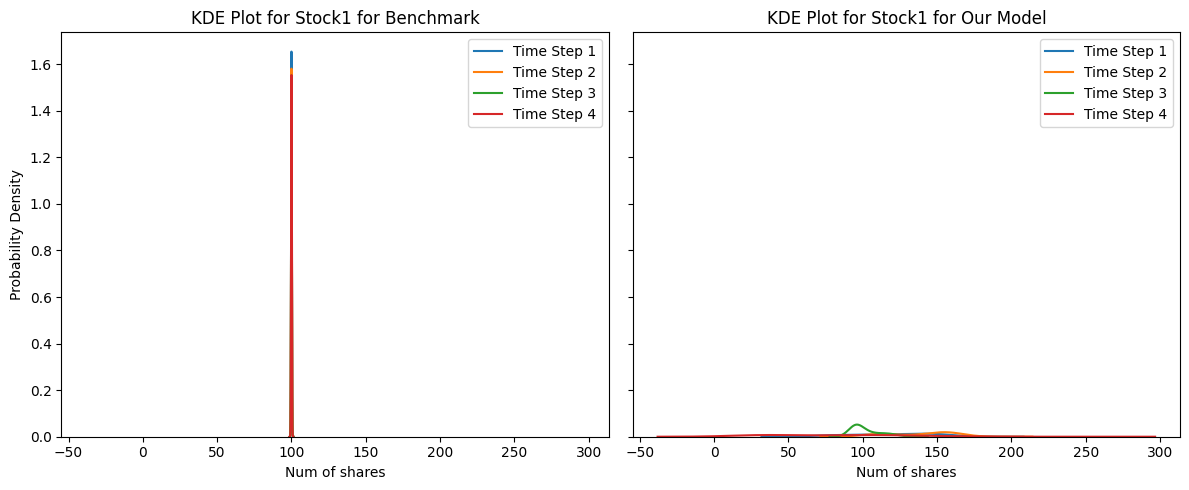

In [26]:
bandwidth=0.5


plot_kde(actions_constraint_OU, actions_bench_constraint_OU, bandwidth=bandwidth)

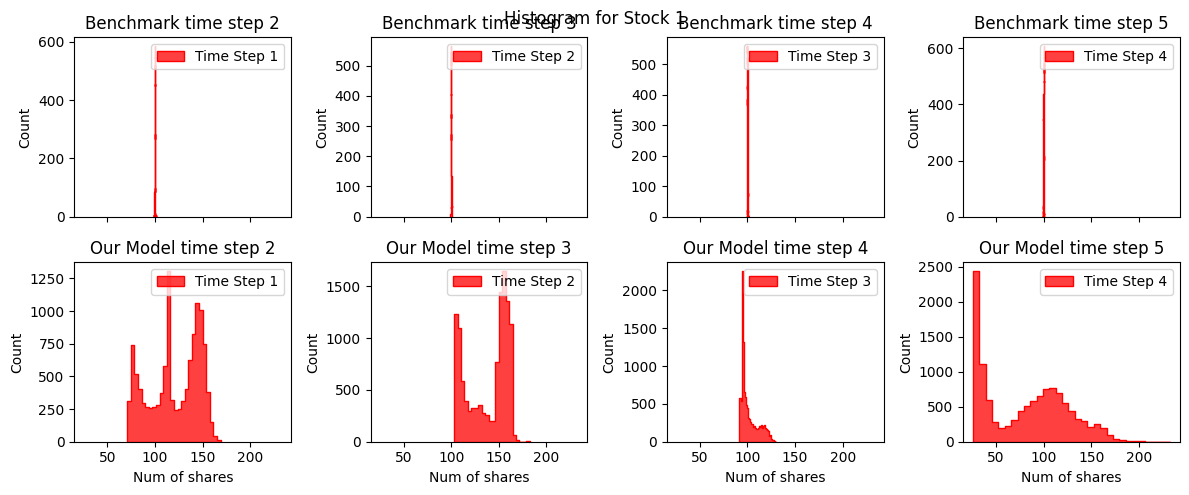

In [27]:
histogram(actions_constraint_OU, actions_bench_constraint_OU)